# Importing modules

In [3]:
import pandas as pd
from psycopg2 import connect
from argparse import Namespace
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import beta
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = 'Arial'

# Setting parameters and defining extracting function

In [4]:
# database config
mimic_args = Namespace(
    dbname = 'mimic',
    dbusr = 'postgres',
    dbpw = 'mimic',
    dbport = 5432,
    dbhost = 'localhost'
)
eicu_args = Namespace(
    dbname = 'eicu',
    dbusr = 'eicu',
    dbpw = 'eicu',
    dbport = 5432,
    dbhost = 'localhost'
)

In [5]:
# Create extraction function (Get dataframe by SQL sentences)
def extract(db_args, sql):
    conn = connect(dbname=db_args.dbname, user=db_args.dbusr,
            password=db_args.dbpw, host=db_args.dbhost, port=db_args.dbport)
    cur = conn.cursor()
    cur.execute(sql)
    targ_df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    cur.close()
    return targ_df

# Does comobidity of cancer influence mortality in different ways?

We have conclusions below:

- Mortaltiy of ICU patients for sergery purpose was not influence by cancer diagnoses
- But for medical purpose, they in deed deteriorated by cancer diagnoses

In [6]:
# Get list of cancer patients
cancodes = ",".join("{0}%".format(code) for code in range(140, 210))
canpts_sql = """
set search_path to mimiciii;
select ad.hadm_id, di.seq_num, di.icd9_code, 
case when di.icd9_code in ('1733','1730','1732','1737','1736','1735','1734','1739','1738','1731')
then 'Oth and unspec malignant neoplasm of skin'
when di.icd9_code = '2333' then 'Carcinoma in situ of breast and genitourinary system'
when di.icd9_code = '2387' then 'Neoplasm of uncertain behavior of other and unspecified sites and tissues'
else did.short_title end as short_title,
case when di.icd9_code in ('1733','1730','1732','1737','1736','1735','1734','1739','1738','1731')
then 'Oth and unspec malignant neoplasm of skin'
when di.icd9_code = '2333' then 'Carcinoma in situ of breast and genitourinary system'
when di.icd9_code = '2387' then 'Neoplasm of uncertain behavior of other and unspecified sites and tissues'
else did.long_title end as long_title 
from admissions ad left join diagnoses_icd di 
on ad.hadm_id = di.hadm_id 
left join d_icd_diagnoses did on di.icd9_code = did.icd9_code
where di.icd9_code like any('{%s}');
""" % cancodes
canpts = extract(mimic_args, canpts_sql)
print (canpts.shape)
pids = canpts.hadm_id.to_list() # Get list of patients diagnosed with cancers
pids_insql = ",".join(str(pid) for pid in pids)

#  get metastatic cancer and lymph-leukemia patients
solid_codes = ",".join("{0}%".format(code) for code in range(140, 196))
sec_codes = ",".join("{0}%".format(code) for code in range(196, 200))
lylm_codes = ",".join("{0}%".format(code) for code in range(200, 209))

sec_lylm_codes = ["""
set search_path to mimiciii;
select ad.hadm_id, di.seq_num, di.icd9_code, did.short_title, did.long_title from admissions ad left join diagnoses_icd di 
on ad.hadm_id = di.hadm_id left join d_icd_diagnoses did on di.icd9_code = did.icd9_code
where di.icd9_code like any('{%s}');
""" % code for code in [solid_codes, sec_codes, lylm_codes]]

sec_pids = extract(mimic_args, sec_lylm_codes[1]).hadm_id.to_list() # metastatic cancer patietns list
lyle_pids = extract(mimic_args, sec_lylm_codes[2]).hadm_id.to_list() # lymphoma and leuokemia patients list

(11932, 5)


In [12]:
tableone_sql = '''
set search_path to mimiciii;
with base_rk as (
select am.subject_id, am.hadm_id, ic.icustay_id, pt.gender, 
round(cast(extract(epoch from (ic.intime - pt.dob)) / (3600 * 24 *365) as numeric)) as age, --round保留整数，cast改变数据类型
ic.first_careunit, ic.intime, ic.outtime, ic.los, am.admission_type, sv.curr_service,
case when pt.dod between am.admittime and am.dischtime then 1 else 0 end as hosp_death,
sf.sofa, sp.sapsii, eq.elixhauser_vanwalraven,
case when vp.starttime - ic.intime < interval '24 hours' then 1 else 0 end as vp_flag, --前24h内有用过血管活性药物
case when vd.starttime - ic.intime < interval '24 hours' then 1 else 0 end as vd_flag, --前24h内有过机械通气的患者
row_number() over (partition by ic.hadm_id order by ic.intime) as rk -- row_number() over (),partition后是分类变量，order by 后是排序变量

from icustays ic left join admissions am on ic.hadm_id = am.hadm_id
left join patients pt on am.subject_id = pt.subject_id
left join sofa sf on ic.icustay_id = sf.icustay_id
left join sapsii sp on ic.icustay_id = sp.icustay_id
left join elixhauser_quan_score eq on ic.hadm_id = eq.hadm_id
left join vasopressordurations vp on ic.icustay_id = vp.icustay_id
left join ventdurations vd on ic.icustay_id = vd.icustay_id
left join services sv on sv.hadm_id = ic.hadm_id)


select t.*, case when hadm_id in (%s) then 'Cancer'
else 'Non-cancer' end as cancer_comorb
from base_rk t where t.rk = 1 and t.age between 16 and 89
and t.outtime - t.intime >= interval '4 hours'
;
''' % pids_insql
tableone_df = extract(mimic_args, tableone_sql).astype({'age': 'int64'})
print (tableone_df.shape)

(46998, 19)


In [339]:
tableone_df['sec_can'] = tableone_df['hadm_id'].apply(lambda x: 1 if x in sec_pids else 0)
tableone_df['lyle_can'] = tableone_df['hadm_id'].apply(lambda x: 1 if x in lyle_pids else 0)

In [8]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [341]:
%%R -i tableone_df
save.image('tableone_df.RData')

# Mortality rate of specific cancer of two database: mimic and eicu

In [9]:
# Parameters
threshold = 10 # Num of diagnosed pateints < threshold will be ignored

In [10]:
# Functions
# def canthre_n(n, can_pid):
#     '''
#     Cancer patients counts set threshold by n and sorted by icd9-code
#     '''
#     canthre_ncount = can_pid.icd9_code.value_counts()
#     canthre_nstr = ','.join("'{0}'".format(code) for code in canthre_ncount.index.to_list())
#     canthre_nsql = """
#     set search_path to mimiciii;
#     select * from d_icd_diagnoses did where did.icd9_code in (%s)
#     """ % canthre_nstr
#     canthre_n = extract(db_args, canthre_nsql)
#     can_countpts = pd.concat((canthre_n, pd.DataFrame({'Count': canthre_ncount.reindex(canthre_n.icd9_code).to_list()})), axis=1).sort_values(by='icd9_code', ascending=True)
#     return can_countpts[can_countpts.Count >= n]

def normalize(df):
    '''
    Normalize sequences of diagnoses
    '''
    if df['max_seq'] == 1:
        return 0
    else:
        return (df['seq_num'] - 1) / (df['max_seq'] - 1)
    
def elbow_plot(data, maxK=10):
    sse = {}
    sse = {}
    sil = {}
    for k in range(1, maxK):
        print ("k: ", k)
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=500, random_state=0).fit(data)
        sse[k] = kmeans.inertia_
        if k != 1:
            sil[k] = silhouette_score(data, kmeans.labels_, metric='euclidean')
        data['cluster'] = kmeans.labels_
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.plot(list(sse.keys()), list(sse.values()), label='elbow')
    plt.subplot(1,2,2)
    plt.plot(list(sil.keys()), list(sil.values()), label='silhouette')
    plt.show()
    return

## MIMIC database

In [13]:
# mort_sql = """set search_path to mimiciii;
# select am.hadm_id, 
# case when pt.dod between am.admittime and am.dischtime then 1 else 0 end as hosp_death
# from admissions am left join patients pt on am.subject_id = pt.subject_id;
# """
print (canpts.shape)
print (tableone_df.shape)
max_seq = """
set search_path to mimiciii;
select hadm_id, max(seq_num) as max_seq from diagnoses_icd group by hadm_id;
""" # Get total number of diagnoses for each patient, in order to normalize the diagnoses sequences of cancer
cantype_mortality = (pd.merge(canpts, tableone_df.loc[:,['hadm_id', 'hosp_death']], how='left', on='hadm_id') # maping the icd9_code to mortality data
                       .pipe(pd.merge, extract(mimic_args, max_seq), how='left', on='hadm_id')).dropna()
print (cantype_mortality.shape)
# can_list = canthre_n(threshold, cantype_mortality.dropna()).icd9_code.to_list() # get icd9 diagnoses that has more than 10 pts
can_thre_codes = pd.DataFrame({'icd9_code': cantype_mortality.icd9_code.value_counts().index,
              'count': cantype_mortality.icd9_code.value_counts()}).loc[lambda x: x['count'] >= threshold]
print (can_thre_codes.shape)
cantype_mortality['norm_seq'] = cantype_mortality.apply(normalize, axis=1)
cantype_mortality = cantype_mortality.dropna()[cantype_mortality.icd9_code.isin(can_thre_codes.icd9_code)]
print ("Threshold of cancer patients number: {0}, The dataframe of 'cantype_mortality' is".format(threshold), cantype_mortality.shape)

(11932, 5)
(46998, 19)
(11174, 7)
(102, 2)
Threshold of cancer patients number: 10, The dataframe of 'cantype_mortality' is (10394, 8)


In [14]:
# Calculating mortality rate of specific cancer
can_dcount = (cantype_mortality.groupby('icd9_code')['hosp_death']
                               .sum()
                               .reset_index())

death_total = pd.concat((can_dcount, (cantype_mortality.icd9_code
                                                       .value_counts()[can_dcount.icd9_code]
                                                       .reset_index(name='Count')
                                                       .drop('icd9_code', axis=1))), axis=1)
                                                
death_total['mort_rate'] = death_total.apply(lambda row: '{0:.2f}%'.format(row.hosp_death / row.Count * 100), axis=1)
# (pd.merge(death_total[['icd9_code']], cantype_mortality[['icd9_code', 'long_title']], how='left', on='icd9_code').drop_duplicates()
# .to_excel('icd9_codes.xlsx')) # Save to file for manu-classify

In [241]:
# Manu-classify the cancer types
manu_cantype = pd.read_excel('icd9_codes.xlsx', header=0, index_col=0).reset_index().astype({'icd9_code': 'str'})
manu_cantype['manu_class_num'] = manu_cantype.manu_class.map({manu_cantype.manu_class.unique()[i]: i for i in range(len(manu_cantype.manu_class.unique()))})
manu_cantype.sort_values(by=['manu_class_num', 'icd9_code'], ascending=True, inplace=True)
death_total = death_total.loc[manu_cantype.icd9_code.index].reset_index(drop=True)

In [242]:
# heatmap
hm_df = pd.DataFrame(cantype_mortality[['icd9_code', 'norm_seq']])
for i in range(1,11):
    hm_df[str(i)] = hm_df.apply(lambda x: 1 if (x.norm_seq >= (i-1)/10 and x.norm_seq < i/10) | (i==10 and x.norm_seq==1) else 0, axis=1)
# print (hm_df)    
hm_df = (hm_df.groupby('icd9_code')
              .sum()
              .loc[manu_cantype.icd9_code, ['%d' % i for i in range(1, 11)]]
              .T
              .apply(lambda x: (x-0)/(max(x)-0), axis=0))

/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: set_ticks() must have been called.


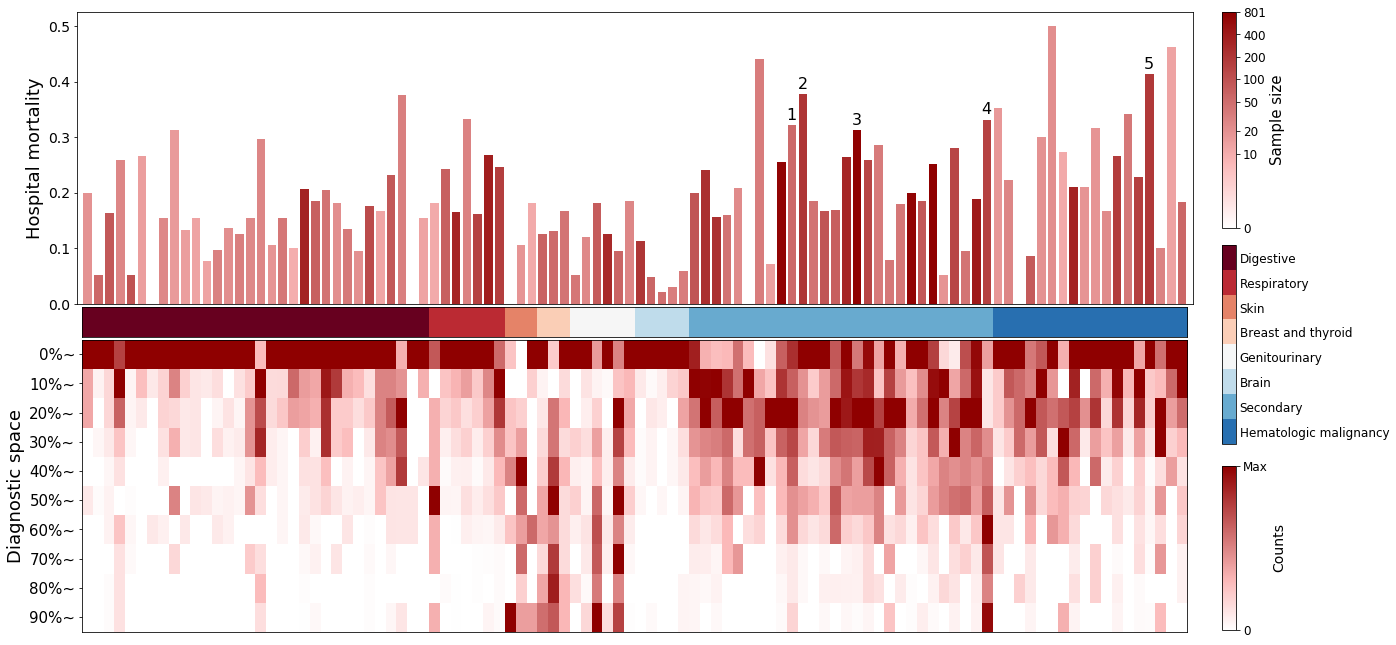

['1971', '1972', '1977', '1991', '20500']


In [261]:
# Visualizing the mortality rate of specific cancer
# Set the grid
fig = plt.figure(figsize=(20, 12))
grid = plt.GridSpec(20, (death_total.shape[0] + 1)*2,  wspace=0.1, hspace=0.1)

# The first subplot: bar
plt.subplot(grid[0:9, 0:(death_total.shape[0] + 1)*2])

# Create cmap of myself
clist1 = [(0, '#ffffff'), (0.3, '#fbb9b9'), (1, '#8f0000')]
clist1 = mcolors.LinearSegmentedColormap.from_list("", clist1)
sm = cm.ScalarMappable(cmap=clist1)

plt.bar(death_total.icd9_code, death_total.hosp_death/death_total.Count, 
        color=clist1(np.log(death_total.Count)/np.log(death_total.Count.max()))) # log transform
# Add labels
labels = death_total[(death_total.hosp_death/death_total.Count >= 0.3) &
                    (death_total.Count >= 50)].icd9_code.to_list()
for i in range(len(labels)):
    plt.annotate(i+1, 
                 xy=(death_total[death_total.icd9_code == labels[i]].index[0], 
                     death_total[death_total.icd9_code == labels[i]].hosp_death/death_total[death_total.icd9_code == labels[i]].Count),
                 xytext=(death_total[death_total.icd9_code == labels[i]].index[0] - 0.5,
                        death_total[death_total.icd9_code == labels[i]].hosp_death/death_total[death_total.icd9_code == labels[i]].Count + 0.01),
#                 arrowprops=dict(facecolor='black', alpha=0.5), 
                fontsize=16
                )
plt.xticks([])
plt.ylabel("Hospital mortality", fontsize=18)
plt.xlim(-1,death_total.shape[0])
plt.yticks(fontsize=14)

# The second subplot: cancertype
plt.subplot(grid[9, 1:((death_total.shape[0] + 1)*2 - 1)])
clist2 = cm.RdBu(range(0, 256, 32))
clist2 = mcolors.LinearSegmentedColormap.from_list("seg", clist2, 8)
cm.register_cmap('seg', clist2)

plt.imshow(np.expand_dims(manu_cantype.manu_class_num.values, axis=0), aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])

# Coloarbars
cbaxe1 = fig.add_axes([0.92, 0.63, 0.01, 0.25])
cbar1 = plt.colorbar(sm, cax=cbaxe1)
cbar1.set_ticks([0, np.log(10) / np.log(death_total.Count.max()),
                np.log(20) / np.log(death_total.Count.max()), 
                np.log(50) / np.log(death_total.Count.max()), 
                np.log(100) / np.log(death_total.Count.max()),
                np.log(200) / np.log(death_total.Count.max()),
                np.log(400)/np.log(death_total.Count.max()), 1])
cbar1.set_ticklabels(['0', '10', '20', '50', '100', '200', '400', '801'])
# cbar1.set_clim(0, 0.5)
cbar1.set_label(label='Sample size', size=15)
cbar1.ax.tick_params(labelsize=12)

cbaxe2 = fig.add_axes([0.92, 0.38, 0.01, 0.23])
plt.clim(-0.5, 8-0.5)
cbar2 = plt.colorbar(cax=cbaxe2)
cbar2.ax.tick_params(length=0, labelsize=12)
cbar2.ax.set_yticklabels(manu_cantype.manu_class.unique())
cbar2.set_ticklabels(manu_cantype.manu_class.unique())
cbar2.ax.invert_yaxis()

# The third subplot: sequence of diagnoses
plt.subplot(grid[10:19, 1:((death_total.shape[0] + 1)*2 - 1)])

plt.imshow(hm_df.values, cmap=clist1, aspect='auto')
plt.xticks([])
plt.yticks(range(0,10),['{0}%~'.format(i*10) for i in range(0,10)], fontsize=15)
plt.ylabel("Diagnostic space", fontsize=18)
cbaxe3 = fig.add_axes([0.92, 0.165, 0.01, 0.19])
cbar3 = plt.colorbar(cax=cbaxe3)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['0', 'Max'])
cbar3.set_label(label='Counts', size=14)
cbar3.ax.tick_params(labelsize=12)
plt.show()
fig.savefig('pics_tables/Figure_1.pdf', bbox_inches="tight")
print (labels)

In [18]:
print ("The note label of figure above were: \n%s" %
      ",\n".join(manu_cantype[manu_cantype.icd9_code.isin(labels)].long_title.to_list())
      )
print ("\n")
print ("The most common type of cancer in MIMIC database was: %s" % \
pd.merge(death_total.sort_values(by='Count', ascending=False), manu_cantype, on='icd9_code').long_title[0])
print ("\n")
print ("The most fatal type of cancer in MIMIC database was: %s" % \
pd.merge(death_total.assign(mortrate=lambda x: x.hosp_death/x.Count).sort_values(by='mortrate', ascending=False), manu_cantype, on='icd9_code').long_title[0])

The note label of figure above were: 
Secondary malignant neoplasm of mediastinum,
Secondary malignant neoplasm of pleura,
Malignant neoplasm of liver, secondary,
Other malignant neoplasm without specification of site,
Acute myeloid leukemia, without mention of having achieved remission


The most common type of cancer in MIMIC database was: Secondary malignant neoplasm of bone and bone marrow


The most fatal type of cancer in MIMIC database was: Mycosis fungoides, unspecified site, extranodal and solid organ sites


In [19]:
#pd.merge(eicu_death_total.sort_values(by='Count', ascending=False), eicu_can_mort[['icd9code', 'diag']], 
          on='icd9code', how='left').drop_duplicates(subset='icd9code', keep='first').drop_duplicates().to_excel('pics_tables/temp.xlsx')

NameError: name 'eicu_death_total' is not defined

In [505]:
#pd.merge(eicu_death_total.assign(mr=lambda x: x.mortality / x.Count).sort_values(by='mr', ascending=False), eicu_can_mort[['icd9code', 'diag']], 
          on='icd9code', how='left').drop_duplicates(subset='icd9code', keep='first').to_excel('pics_tables/temp.xlsx')

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


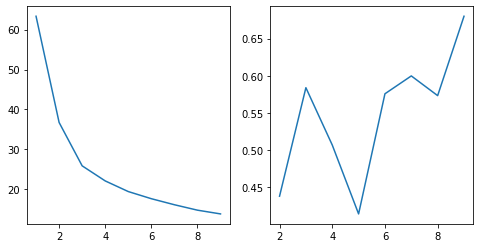

In [348]:
# k-mean of diag_seq number
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
elbow_plot(hm_df.T, maxK=10) # The function created in the blow

In [349]:
K = 3
diag_kmeans = KMeans(n_clusters=K, max_iter=500, n_init=100, random_state=0).fit(hm_df.T)
diag_cluster = diag_kmeans.labels_
cluster_hm = hm_df.iloc[:, np.argsort(diag_cluster)]

/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: set_ticks() must have been called.


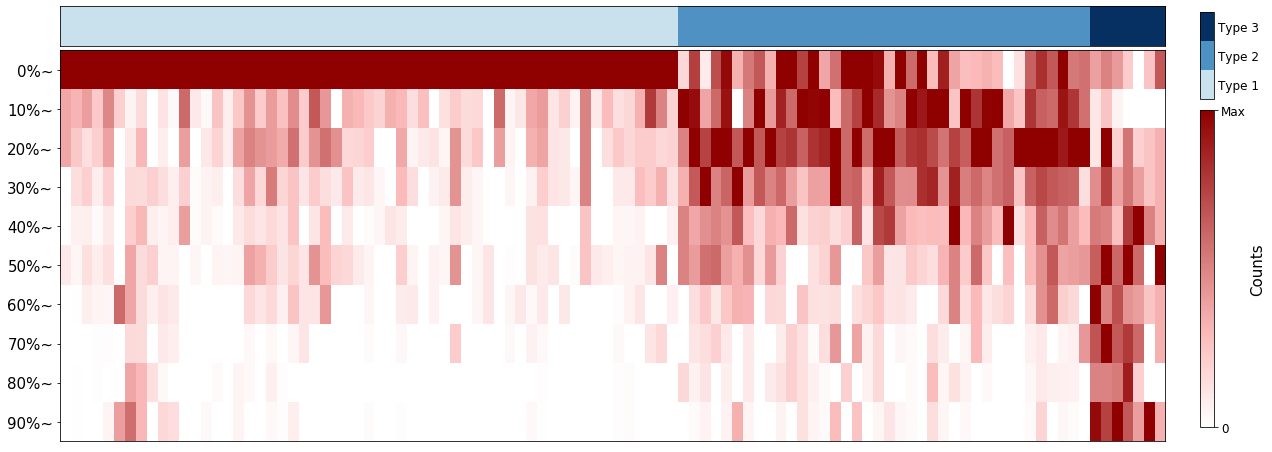

In [350]:
# visualize the cluster of diagnoses (we will make it to a supplementary plot, sorted by kmeans)
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(10, (death_total.shape[0] + 1)*2,  wspace=0.1, hspace=0.1)

clist3 = cm.RdBu(range(156, 256, 33))
clist3 = mcolors.LinearSegmentedColormap.from_list("seg", clist3, 3)
cm.register_cmap('seg', clist3)

plt.subplot(grid[0, 1:((death_total.shape[0] + 1)*2 - 1)])
plt.imshow(np.expand_dims(np.sort(diag_cluster), axis=0), aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])


cbaxe1 = fig.add_axes([0.92, 0.72, 0.01, 0.15])
plt.clim(-0.5, 3-0.5)
cbar1 = plt.colorbar(cax=cbaxe1)
cbar1.ax.tick_params(length=0, labelsize=12)
cbar1.ax.set_yticklabels(['Type {0}'.format(i+1) for i in range(K)])
cbar1.set_ticklabels(['Type {0}'.format(i+1) for i in range(K)])

# The forth subplot: sequence of diagnoses
plt.subplot(grid[1:10, 1:((death_total.shape[0] + 1)*2 - 1)])

plt.imshow(cluster_hm.values, cmap=clist1, aspect='auto')
plt.xticks([])
plt.yticks(range(0,10),['{0}%~'.format(i*10) for i in range(0,10)], fontsize=15)
cbaxe2 = fig.add_axes([0.92, 0.15, 0.01, 0.55])
cbar2 = plt.colorbar(cax=cbaxe2)
cbar2.set_ticks([0,1])
cbar2.set_ticklabels(['0', 'Max'])
cbar2.set_label(label='Counts', size=15)
cbar2.ax.tick_params(labelsize=12)
plt.show()

In [20]:
# get second-cancer and lymph-leukemia patient ids
solid_codes = ",".join("{0}%".format(code) for code in range(140, 196)) + ',' + ",".join("{0}%".format(code) for code in range(209, 240))
sec_codes = ",".join("{0}%".format(code) for code in range(196, 200))
lylm_codes = ",".join("{0}%".format(code) for code in range(200, 209))

sec_lylm_codes = ["""
set search_path to mimiciii;
select ad.hadm_id, di.seq_num, di.icd9_code, did.short_title, did.long_title from admissions ad left join diagnoses_icd di 
on ad.hadm_id = di.hadm_id left join d_icd_diagnoses did on di.icd9_code = did.icd9_code
where di.icd9_code like any('{%s}');
""" % code for code in [solid_codes, sec_codes, lylm_codes]]

sec_pids = extract(mimic_args, sec_lylm_codes[1]).hadm_id.to_list()
lyle_pids = extract(mimic_args, sec_lylm_codes[2]).hadm_id.to_list()

solid_pids = list(set(extract(mimic_args, sec_lylm_codes[0]).hadm_id.to_list()) - set(sec_pids) - set(lyle_pids)) # solid without metastasis

## eICU database

In [21]:
eicu_can_mort_sql = """
set search_path to eicu_crd;

select dg.patientunitstayid as pid, case when pt.age like '> 89' or age like '' then null else cast(age as numeric) end as age, 
dg.icd9code, dg.diagnosisstring as diag, dg.diagnosispriority as prior,
case when lower(pt.hospitaldischargelocation) like 'death' then 1 else 0 end as mortality
from diagnosis dg left join apachepatientresult aps on dg.patientunitstayid = aps.patientunitstayid 
left join patient pt on dg.patientunitstayid = pt.patientunitstayid
where aps.apacheversion = 'IV' and aps.actualiculos >= 4/24
and dg.activeupondischarge = 'True'
and dg.icd9code like any('{%s}');
""" % cancodes
eicu_can_mort = extract(eicu_args, eicu_can_mort_sql).loc[lambda x: (x.age >= 16) & (x.age <89)].drop('age', axis=1)
eicu_can_mort

,pid,icd9code,diag,prior,mortality
0,141340,"191.9, C71.9",neurologic|CNS mass lesions|brain tumor,Primary,0
1,141800,"197.0, C78.00",oncology|chest tumors|metastatic lung CA,Other,1
2,141454,"204.10, C91.10",oncology|hematologic malignancy|leukemia|chron...,Major,0
3,141800,"170.9, C41.9","oncology|skin, muscle and skeletal tumors|bone...",Other,1
4,141923,"162.9, C34.90",oncology|chest tumors|primary lung cancer,Other,1
5,142099,"191.9, C71.9",oncology|CNS tumors|brain tumor|glioblastoma m...,Primary,0
6,142129,"162.9, C34.90",oncology|chest tumors|primary lung cancer,Other,0
7,143550,"204.10, C91.10",oncology|hematologic malignancy|leukemia|chron...,Other,0
8,142858,"191.9, C71.9",neurologic|CNS mass lesions|brain tumor|mening...,Primary,0
9,142153,"204.10, C91.10",hematology|oncology and leukemia|leukemia|chro...,Primary,1


In [412]:
# all_counts_sql = """
# set search_path to eicu_crd;
# select count(distinct patientunitstayid) from apachepatientresult aps
# where aps.apacheversion = 'IV' and aps.actualiculos >= 4/24;"""

# extract(eicu_args, all_counts_sql)

,count
0,148532


In [22]:
# Calculating mortality rate of specific cancer for eicu
eicu_can_dcount = (eicu_can_mort.groupby('icd9code')['mortality']
                                .sum()
                                .reset_index())

eicu_death_total = pd.concat((eicu_can_dcount, (eicu_can_mort.icd9code
                                                             .value_counts()[eicu_can_dcount.icd9code]
                                                             .reset_index(name='Count')
                                                             .drop('icd9code', axis=1))), axis=1).loc[lambda x: x.Count >= 10].reset_index(drop=True)
                                                
eicu_death_total['mort_rate'] = eicu_death_total.apply(lambda row: '{0:.2f}%'.format(row.mortality / row.Count * 100), axis=1)
# (pd.merge(eicu_death_total[['icd9code']], eicu_can_mort[['icd9code', 'diag']], how='left', on='icd9code').drop_duplicates('icd9code')
# .to_excel('eicu_icd9_codes.xlsx')) # Save to file for manu-classify

In [354]:
# pd.merge(eicu_death_total[['icd9code']], eicu_can_mort[['icd9code', 'diag']], how='left', on='icd9code').drop_duplicates('icd9code').shape

(47, 2)

In [249]:
# Manu-classify the cancer types
eicu_manu_cantype = pd.read_excel('eicu_icd9_codes.xlsx', header=0, index_col=0).reset_index().astype({'icd9code': 'str'})
eicu_manu_cantype['manu_class_num'] = eicu_manu_cantype.manu_class.map({eicu_manu_cantype.manu_class.unique()[i]: i for i in range(len(eicu_manu_cantype.manu_class.unique()))})
eicu_manu_cantype.sort_values(by=['manu_class_num', 'icd9code'], ascending=True, inplace=True)
eicu_death_total = eicu_death_total.loc[eicu_manu_cantype.icd9code.index].reset_index(drop=True)

In [250]:
# heatmap
eicu_hm_df = pd.DataFrame(eicu_can_mort[['icd9code', 'prior']])
for i in ['Primary', 'Major', 'Other']:
    eicu_hm_df[i] = eicu_hm_df.apply(lambda x: 1 if x.prior == i else 0, axis=1)
eicu_hm_df = (eicu_hm_df.drop('prior', axis=1)
                        .groupby('icd9code')
                        .sum()
                        .loc[eicu_manu_cantype.icd9code, ]
                        .T
                        .apply(lambda x: (x-0)/(max(x)-0), axis=0))
eicu_hm_df

icd9code,"145.9, C06.9","148.9, C13.9","161.9, C32.9","151.9, C16.9","152.9, C17.9","153.0, C18.3","153.3, C18.7","153.4, C18.0","153.9, C18.9","154.3, C18.0",...,"199.0, C80.0","199.1, C80.1","201.90, C81.90","202.80, C85.80","202.82, C85.82","203.00, C90.00","204.00, C91.00","204.10, C91.10","205.00, C92.00","205.10, C92.10"
Primary,0.918367,1.000000,0.672414,0.185185,0.277778,0.625,0.066667,0.75,0.133333,0.392857,...,0.2,0.2,0.00,0.063492,0.173913,0.088235,0.25,0.083333,0.173333,0.111111
Major,1.000000,0.952381,1.000000,1.000000,1.000000,1.000,1.000000,1.00,1.000000,0.678571,...,0.6,0.8,0.72,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
Other,0.755102,0.952381,0.706897,0.469136,0.861111,0.625,0.733333,0.75,0.823810,1.000000,...,1.0,1.0,1.00,0.674603,0.782609,0.725490,0.55,1.000000,0.653333,0.666667


/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: set_ticks() must have been called.


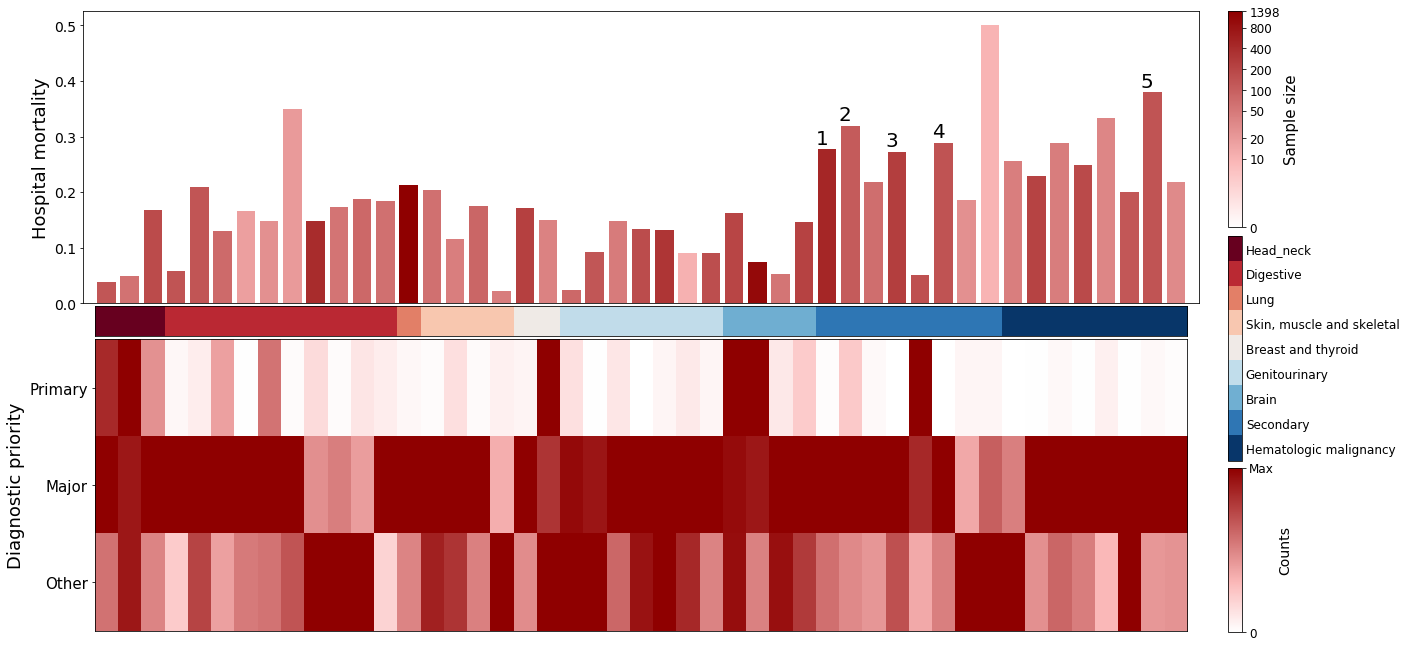

['197.0, C78.00', '197.2, J91.0', '197.7, C78.7', '198.5, C79.51', '205.00, C92.00']


In [262]:
# Visualizing the mortality rate of specific cancer
# Set the grid
fig = plt.figure(figsize=(20, 12))
grid = plt.GridSpec(20, (eicu_death_total.shape[0] + 1)*2,  wspace=0.1, hspace=0.1)

# The first subplot: bar
plt.subplot(grid[0:9, 0:(eicu_death_total.shape[0] + 1)*2])

# Create cmap of myself
clist1 = [(0, '#ffffff'), (0.3, '#fbb9b9'), (1, '#8f0000')]
clist1 = mcolors.LinearSegmentedColormap.from_list("", clist1)
sm = cm.ScalarMappable(cmap=clist1)

plt.bar(eicu_death_total.icd9code, eicu_death_total.mortality/eicu_death_total.Count, 
        color=clist1(np.log(eicu_death_total.Count)/np.log(eicu_death_total.Count.max()))) # log transform
# Add labels
eicu_labels = eicu_death_total[(eicu_death_total.mortality/eicu_death_total.Count >= 0.25) &
                    (eicu_death_total.Count >= 50)].icd9code.to_list()
for i in range(len(eicu_labels)):
    plt.annotate(i+1, 
                 xy=(eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].index[0], 
                     eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].mortality/eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].Count),
                 xytext=(eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].index[0] - 0.5,
                        eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].mortality/eicu_death_total[eicu_death_total.icd9code == eicu_labels[i]].Count + 0.01),
#                 arrowprops=dict(facecolor='black', alpha=0.5), 
                 fontsize=20
                )
plt.xticks([])
plt.xlim(-1,eicu_death_total.shape[0])
plt.yticks(fontsize=14)
plt.ylabel("Hospital mortality", fontsize=18)

# The second subplot: cancertype
plt.subplot(grid[9, 1:((eicu_death_total.shape[0] + 1)*2 - 1)])
clist2 = cm.RdBu(range(0, 256, 28))
clist2 = mcolors.LinearSegmentedColormap.from_list("seg", clist2, 9)
cm.register_cmap('seg', clist2)

plt.imshow(np.expand_dims(eicu_manu_cantype.manu_class_num.values, axis=0), aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])

# Coloarbars
cbaxe1 = fig.add_axes([0.92, 0.63, 0.01, 0.25])
cbar1 = plt.colorbar(sm, cax=cbaxe1)
cbar1.set_ticks([0, np.log(10) / np.log(eicu_death_total.Count.max()),
                np.log(20) / np.log(eicu_death_total.Count.max()), 
                np.log(50) / np.log(eicu_death_total.Count.max()), 
                np.log(100) / np.log(eicu_death_total.Count.max()),
                np.log(200) / np.log(eicu_death_total.Count.max()),
                np.log(400)/np.log(eicu_death_total.Count.max()), 
                np.log(800)/np.log(eicu_death_total.Count.max()), 1])
cbar1.set_ticklabels(['0', '10', '20', '50', '100', '200', '400', '800', '1398'])
cbar1.set_label(label='Sample size', size=15)
cbar1.ax.tick_params(labelsize=12)

cbaxe2 = fig.add_axes([0.92, 0.36, 0.01, 0.26])
plt.clim(-0.5, 9-0.5)
cbar2 = plt.colorbar(cax=cbaxe2)
cbar2.ax.tick_params(length=0, labelsize=12)
cbar2.ax.set_yticklabels(eicu_manu_cantype.manu_class.unique())
cbar2.set_ticklabels(eicu_manu_cantype.manu_class.unique())
cbar2.ax.invert_yaxis()

# The third subplot: sequence of diagnoses
plt.subplot(grid[10:19, 1:((eicu_death_total.shape[0] + 1)*2 - 1)])

plt.imshow(np.square(eicu_hm_df.values), cmap=clist1, aspect='auto')
plt.xticks([])
plt.yticks([0,1,2], ['Primary', 'Major', 'Other'], fontsize=15)
plt.ylabel("Diagnostic priority", fontsize=18)
cbaxe3 = fig.add_axes([0.92, 0.162, 0.01, 0.19])
cbar3 = plt.colorbar(cax=cbaxe3)
cbar3.set_ticks([0,1])
cbar3.set_ticklabels(['0', 'Max'])
cbar3.set_label(label='Counts', size=14)
cbar3.ax.tick_params(labelsize=12)
plt.show()
fig.savefig('pics_tables/SFigure_1.pdf', bbox_inches="tight")
print (eicu_labels)

In [248]:
# print (pd.merge(eicu_death_total.sort_values(by='Count', ascending=False), eicu_manu_cantype, on='icd9code').diag[0])
# pd.merge(eicu_death_total.assign(mortrate=lambda x: x.mortality/x.Count).sort_values(by='mortrate', ascending=False), eicu_manu_cantype, on='icd9code')

print ("The note label of figure above were: \n%s" %
      ",\n".join(eicu_manu_cantype[eicu_manu_cantype.icd9code.isin(eicu_labels)].diag.to_list())
      )
print ("\n")
print ("The most common type of cancer in MIMIC database was: %s" % \
pd.merge(eicu_death_total.sort_values(by='Count', ascending=False), eicu_manu_cantype, on='icd9code').diag[0])
print ("\n")
print ("The most fatal type of cancer in MIMIC database was: %s" % \
pd.merge(eicu_death_total.assign(mortrate=lambda x: x.mortality/x.Count).sort_values(by='mortrate', ascending=False), eicu_manu_cantype, on='icd9code').diag[0])

The note label of figure above were: 
oncology|chest tumors|metastatic lung CA,
pulmonary|pleural disorders|pleural effusion|malignant,
oncology|GI tumors|liver CA|CA metastatic to liver,
oncology|skin, muscle and skeletal tumors|bone tumors|bony metastasis,
hematology|oncology and leukemia|leukemia|acute myelogenous


The most common type of cancer in MIMIC database was: oncology|chest tumors|primary lung cancer


The most fatal type of cancer in MIMIC database was: oncology|unknown primary|metastatic adenocarcinoma|unknown primary


# clinical subtypes have different characters

We don't use any scoring systems and outcomes in the k-mean clustering

## Kmean clustering 4

In [31]:
# Get all clinical features
mval_sql = """
set search_path to mimiciii;

-- get fio
with fio as (with temp as (select ic.icustay_id, case when ce.itemid = 190 then ce.valuenum else ce.valuenum/100 end fio from icustays ic left join chartevents ce  
on ic.icustay_id = ce.icustay_id where ce.charttime between ic.intime and ic.intime + interval '1 day'
and ce.valuenum is not null and ce.itemid in (3420, 190, 3422, 223835))
select temp.icustay_id, 
case when avg(temp.fio) < 0.2 then null when avg(temp.fio) > 1 then null else avg(temp.fio) end as fio_mean 
from temp group by temp.icustay_id),

bgs as ( -- lung functions, we should find FIO2 on chartevent to avoid missing data on oxigen index
with fio as (with temp as (select ic.icustay_id, case when ce.itemid = 190 then ce.valuenum else ce.valuenum/100 end fio from icustays ic left join chartevents ce  
on ic.icustay_id = ce.icustay_id where ce.charttime between ic.intime and ic.intime + interval '1 day'
and ce.valuenum is not null and ce.itemid in (3420, 190, 3422, 223835))
select temp.icustay_id, avg(temp.fio) as fio_mean from temp group by temp.icustay_id),

bgm as (
select ic.icustay_id, avg(bgf.po2) as po2, avg(bgf.pco2) as pco2, 
avg(bgf.pao2fio2) as oi, avg(bgf.ph) as ph from icustays ic left join bloodgasfirstdayarterial bgf on ic.icustay_id = bgf.icustay_id 
group by ic.icustay_id)

--with bgs as ( -- lung functions, we should find FIO2 on chartevent to avoid missing data on oxigen index
select ic.icustay_id, bgm.po2, bgm.pco2, 
case when bgm.oi is null then bgm.po2/fio.fio_mean else bgm.oi end as oi,
bgm.ph from icustays ic left join bgm on ic.icustay_id = bgm.icustay_id 
left join fio on ic.icustay_id = fio.icustay_id where fio.fio_mean is not null and fio_mean != 0),

glucose as ( -- two tables (labsfirstday and vitalsfirstday) have glucose, we combine them to avoid missing data
select ic.icustay_id, case when lf.glucose_mean is null then vf.glucose_mean else lf.glucose_mean end as glucose_mean 
from icustays ic left join labsfirstday lf on ic.icustay_id = lf.icustay_id
full outer join vitalsfirstday vf on lf.icustay_id = vf.icustay_id),

cvp as (
select ic.icustay_id, 
case when avg(ce.valuenum) < -5 then -5
when avg(ce.valuenum) > 30 then 30 
else avg(ce.valuenum) end as cvp_mean from icustays ic left join 
chartevents ce on ic.icustay_id = ce.icustay_id where ce.itemid in (113, 220074)
and ce.charttime between ic.intime and ic.intime + interval '1 day'
group by ic.icustay_id),

base_rk as (
select am.subject_id, ic.icustay_id, pt.gender, 
round(cast(extract(epoch from(ic.intime - pt.dob))/(3600*24*365) as numeric)) as age, --第一次入院年龄
ic.first_careunit, am.admission_type, sv.curr_service, ic.los, rf.rrt,
case when pt.dod between am.admittime and am.dischtime then 1 else 0 end as hosp_death,
case when pt.dod between am.admittime and admittime + interval '28' day then 1 else 0 end as d28_death,
sf.sofa, sp.sapsii, cm.*, eq.elixhauser_vanwalraven,
case when vp.duration_hours > 0 then 1 else 0 end as vp_flag,
case when vd.duration_hours > 0 then 1 else 0 end as vent_flag,
vf.heartrate_mean, vf.meanbp_mean, vf.tempc_mean, vf.spo2_mean, --vital signs
lf.albumin_mean, lf.bilirubin_mean, lf.creatinine_mean, lf.bun_mean, gc.glucose_mean, lf.hematocrit_mean,
lf.lactate_mean, lf.platelet_mean, lf.potassium_mean, lf.inr_mean, lf.sodium_mean, 
lf.wbc_mean, gf.mingcs, cvp.cvp_mean, 
bgs.po2, bgs.pco2, bgs.oi, bgs.ph,
row_number() over (partition by ic.hadm_id order by ic.intime) as rk
from icustays ic left join admissions am on ic.hadm_id = am.hadm_id
left join patients pt on am.subject_id = pt.subject_id
left join services sv on am.hadm_id = sv.hadm_id
left join sofa sf on ic.icustay_id = sf.icustay_id
left join sapsii sp on ic.icustay_id = sp.icustay_id
left join comorbidities cm on ic.hadm_id = cm.hadm_id
left join elixhauser_quan_score eq on ic.hadm_id = eq.hadm_id
left join vasopressordurations vp on ic.icustay_id = vp.icustay_id
left join ventdurations vd on ic.icustay_id = vd.icustay_id
left join vitalsfirstday vf on ic.icustay_id = vf.icustay_id
left join labsfirstday lf on ic.icustay_id = lf.icustay_id
left join gcsfirstday gf on ic.icustay_id = gf.icustay_id
left join glucose gc on ic.icustay_id = gc.icustay_id
left join fio on fio.icustay_id = ic.icustay_id 
left join bgs on bgs.icustay_id = ic.icustay_id
left join cvp on cvp.icustay_id = ic.icustay_id
left join rrtfirstday rf on rf.icustay_id = ic.icustay_id
where am.hadm_id in (%s))
select t.* from base_rk t left join icustays ic on t.icustay_id = ic.icustay_id 
where t.rk = 1 and age between 16 and 89 
and ic.outtime - ic.intime >= interval '4 hours'; 
""" % pids_insql

mval_df_original = extract(mimic_args, mval_sql)
print (mval_df_original.shape)
# all is 46998

(6505, 48)


In [220]:
# Preprocessing: new variables
def oridf_shift(mval_df_original):
    mval_df = mval_df_original.copy()
    mval_df['sec_can'] = mval_df['hadm_id'].apply(lambda x: 1 if x in sec_pids else 0)
    mval_df['lyle_can'] = mval_df['hadm_id'].apply(lambda x: 1 if x in lyle_pids else 0)
    mval_df['sol_can'] = mval_df['hadm_id'].apply(lambda x: 1 if x in solid_pids else 0)
    mval_df['from_surgery'] = mval_df['curr_service'].apply(lambda x: 1 if x in ['CSURG', 'NSURG', 'ORTHO', 'PSURG', 'SURG', 'TSURG', 'VSURG'] else 0)
    mval_df['from_medical'] = mval_df['curr_service'].apply(lambda x: 1 if x in ['CMED', 'MED'] else 0)
    mval_df = mval_df.drop('curr_service', axis=1)
    return mval_df
mval_df = oridf_shift(mval_df_original)

# Preprocessing: Missing variables counts
print(mval_df.isnull().sum(axis=0))

# Preprocessing: shift dtypes, dummy, mapping, impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
catev_todum = ['first_careunit', 'admission_type'] # Features need to dummy
del_cols = ['subject_id', 'icustay_id', 'los', 'hosp_death', 'd28_death', 'hadm_id', 'rk', 'sapsii', 'sofa', 'elixhauser_vanwalraven'] # features need to delete
def preprocess(df=mval_df, strategy='mean', catev_todum = ['first_careunit', 'admission_type'], del_cols=del_cols):
    '''
    This function preprocesses the dataframe, by change age and gender to integer.
    And impute missing value by different strategies: mean, median, mice, knn
    '''
    # age to be integer
    df.age = df.age.astype(int)
    # gender map to integer
    df.gender = df.gender.map({'F': 0, 'M': 1}).astype(int)
    # dummy
    df = pd.get_dummies(df, columns=catev_todum)
    # throw out non-sense columns for kmeans
    cols = sorted(set(df.columns) - set(del_cols), key=df.columns.to_list().index)
    # impute
    print ("Below features have missing values, we impute by strategy of %s :" % strategy)
    for mis_col in df.columns[df.isnull().sum()>0]: # 1 is for curr_service
        print (mis_col)
    if strategy in ('mean', 'median'):
        imputer = SimpleImputer(strategy=strategy)
    elif strategy == 'multivariate':
        imputer = IterativeImputer(max_iter=10, random_state=0)
    elif strategy == 'knn':
        imputer = KNNImputer(n_neighbors=2, weights='uniform')
    else:
        print ("Strategy setting error")
    impute_df = pd.DataFrame(imputer.fit(df).transform(df), columns=df.columns)
    # normalization
    std_scaler = StandardScaler().fit(impute_df[cols])
    df_norm = pd.DataFrame(std_scaler.transform(impute_df[cols]), columns=cols)
    return df, df_norm # the imputed data and normalized data

mval_df, km_df = preprocess(mval_df, strategy='multivariate') # the imputed dataframe and normalized dataframe

subject_id                   0
icustay_id                   0
gender                       0
age                          0
first_careunit               0
admission_type               0
los                          0
rrt                          0
hosp_death                   0
d28_death                    0
sofa                         0
sapsii                       0
hadm_id                      0
icd_chf                      0
icd_afib                     0
icd_renal                    0
icd_liver                    0
icd_copd                     0
icd_cad                      0
icd_stroke                   0
icd_malignancy               0
elixhauser_vanwalraven      10
vp_flag                      0
vent_flag                    0
heartrate_mean              87
meanbp_mean                 89
tempc_mean                 137
spo2_mean                   98
albumin_mean              3834
bilirubin_mean            3277
creatinine_mean             56
bun_mean                    59
glucose_

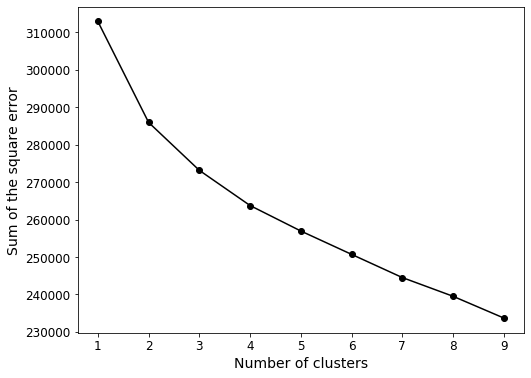

In [691]:
# Elbow of kmean
# elbow_plot(km_df)

# def elbow_plot(data, maxK=10):
# sse = {}
# for k in range(1, 10):
#     print ("k: ", k)
#     kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=500, random_state=0).fit(km_df)
#     sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(8, 6))
# plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()), label='elbow', color='black', marker='o')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Sum of the square error", fontsize=14)
# plt.subplot(1,2,2)
# plt.plot(list(sil.keys()), list(sil.values()), label='silhouette')
plt.show()
fig.savefig("Pics_tables/SFigure_4.pdf")

In [464]:
# We choose K from 2 to 4, but we just desplay for 4
k = 4
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=500, random_state=0).fit(km_df)
km_df['cluster'] = kmeans.labels_
km_df['hosp_death'] = mval_df.hosp_death
# km_df.iloc[:, -2:]

In [276]:
# np.save('kmean_saved/kmean_4.npy', kmeans.labels_)
km_df['cluster'] = np.load('kmean_saved/kmean_4.npy')
km_df['hosp_death'] = mval_df.hosp_death

In [277]:
# Order the clusters
cluster_sorted = (np.argsort([(km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0]),
            (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0]),
            (km_df[km_df.cluster == 2].hosp_death.sum() / km_df[km_df.cluster == 2].shape[0]),
            (km_df[km_df.cluster == 3].hosp_death.sum() / km_df[km_df.cluster == 3].shape[0])]))
km_df['cluster'] = km_df['cluster'].apply(lambda x: list(cluster_sorted).index(x))
# Test by mortality rate
print ('The mortality of three subgroups are')
print (km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0])
print (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0])
print (km_df[km_df.cluster == 2].hosp_death.sum() / km_df[km_df.cluster == 2].shape[0])
print (km_df[km_df.cluster == 3].hosp_death.sum() / km_df[km_df.cluster == 3].shape[0])

The mortality of three subgroups are
0.04003079291762895
0.11838235294117647
0.20361362056984017
0.46487603305785125


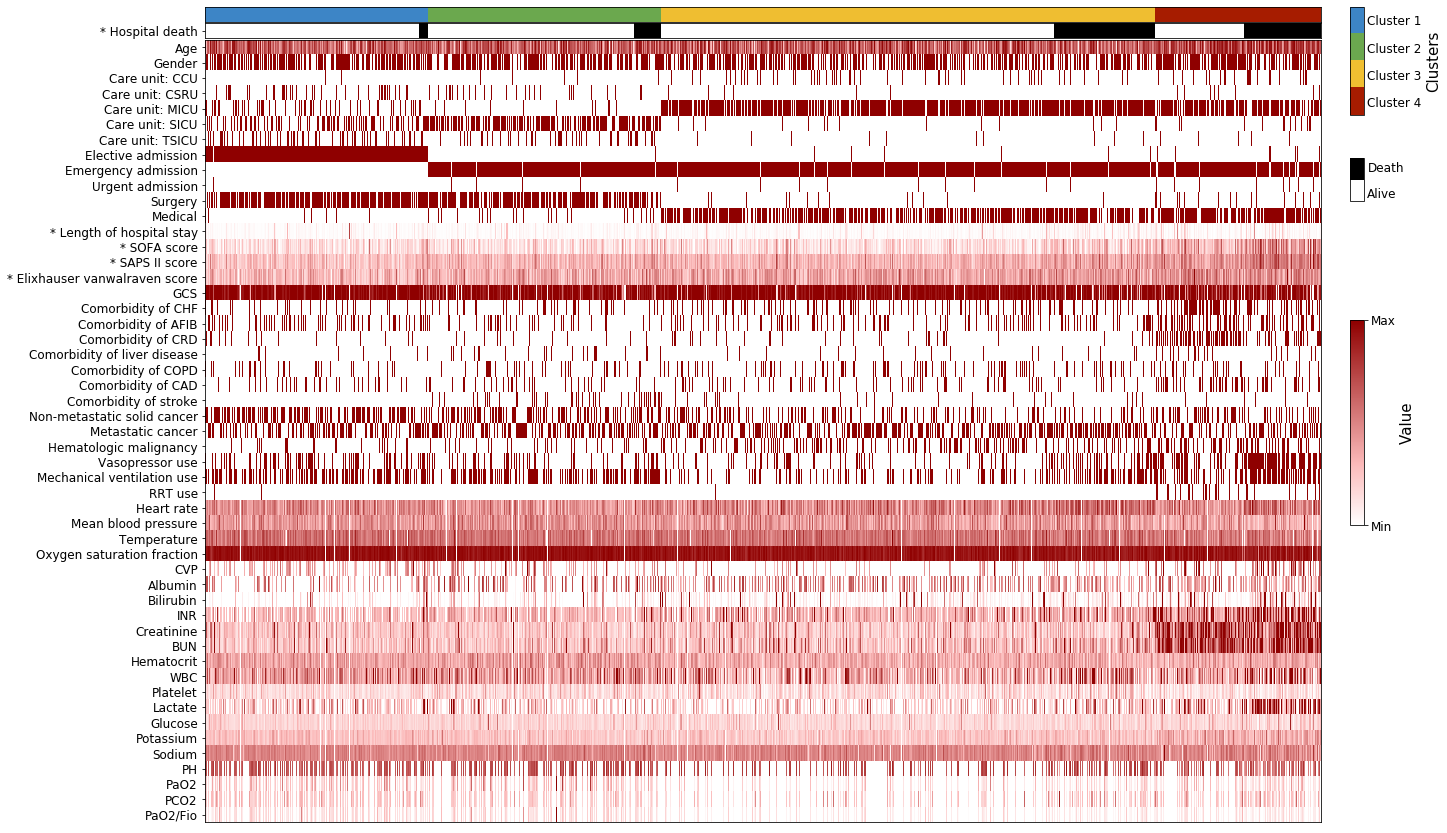

In [278]:
# Prepare for visulization
manu_cols = ['age','gender', 'first_careunit_CCU', 'first_careunit_CSRU',
       'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 'admission_type_URGENT', 
       'from_surgery', 'from_medical', 'los', 'sofa', 'sapsii', 'elixhauser_vanwalraven', 'mingcs', 
       'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 
       'sol_can', 'sec_can', 'lyle_can', 
       'vp_flag', 'vent_flag', 'rrt', 'heartrate_mean',
       'meanbp_mean', 'tempc_mean', 'spo2_mean', 'cvp_mean', 
       'albumin_mean', 'bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 
       'hematocrit_mean', 'wbc_mean', 'platelet_mean', 'lactate_mean', 'glucose_mean', 'potassium_mean',
       'sodium_mean', 'ph', 'po2', 'pco2', 'oi', 'cluster', 'hosp_death']
mval_df['cluster'] = km_df['cluster']
kmv_df = mval_df[manu_cols].sort_values(by=['cluster', 'hosp_death'])

# transforming the data for visulization
def man_outlier(x, col, df):
    if x > df[col].quantile(0.95):
        return df[col].quantile(0.95)
    else:
        return x
trs_cols = ['bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 'wbc_mean', 'lactate_mean']
for col in trs_cols:
    kmv_df[col] = mval_df[col].apply(man_outlier, col=col, df=mval_df)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
kmv_df = pd.DataFrame(min_max_scaler.fit_transform(kmv_df), columns=manu_cols)

# Visualizing the non-normalized dataset with clusters and hospital_death
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(50, 1,  wspace=0.1, hspace=0.1)

# The first two subplot: cluster and hospital death

clist1 = [(0, '#3d85c6'), (0.33, '#6aa84f'), (0.66, '#f1c232'), (1, '#a61c00')]
clist1 = mcolors.LinearSegmentedColormap.from_list("seg", clist1, 4)
# sm = cm.ScalarMappable(cmap=clist1)
cm.register_cmap('seg', clist1)
plt.subplot(grid[0, 0])

plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['cluster']].values.T, 
           aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])

cbaxe1 = fig.add_axes([0.92, 0.78, 0.01, 0.1])
plt.clim(-0.16, 1+0.16)
cbar1 = plt.colorbar(cax=cbaxe1, ticks=kmv_df.cluster.unique())
cbar1.ax.tick_params(length=0, labelsize=12)
cbar1.ax.set_yticklabels(["Cluster {0}".format(i+1) for i in range(4)])
# cbar1.ax.set_yticklabels(kmv_df.cluster.unique())
cbar1.ax.invert_yaxis()
cbar1.set_label(label='Clusters', size=15)

plt.subplot(grid[1, 0])
clist2 = [(0, 'white'), (1, 'black')]
clist2 = mcolors.LinearSegmentedColormap.from_list("wb", clist2, 2)
cm.register_cmap('wb', clist2)


plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['hosp_death']].values.T, 
           aspect='auto', cmap='wb')
plt.xticks([])
plt.yticks([0], ['* Hospital death'], fontsize=12)
cbaxe2 = fig.add_axes([0.92, 0.70, 0.01, 0.04])
plt.clim(-0.33, 1+0.33)
cbar2 = plt.colorbar(cax=cbaxe2, ticks=range(2))
cbar2.ax.tick_params(length=0, labelsize=12)
cbar2.ax.set_yticklabels(["Alive", 'Death'])

# The heatmap of clinical data
plt.subplot(grid[2:50, 0])
clist2 = [(0, '#ffffff'), (0.3, '#fbb9b9'), (1, '#8f0000')]
clist2 = mcolors.LinearSegmentedColormap.from_list("myself", clist2)

plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[manu_cols[0:-2]].values.T,
          aspect='auto', cmap=clist2)

ylabels = [
    'Age',
    'Gender',
    'Care unit: CCU',
    'Care unit: CSRU',
    'Care unit: MICU',
    'Care unit: SICU',
    'Care unit: TSICU',
    'Elective admission',
    'Emergency admission',
    'Urgent admission',
    'Surgery',
    'Medical',
    '* Length of hospital stay',
    '* SOFA score',
    '* SAPS II score',
    '* Elixhauser vanwalraven score',
    'GCS',
    'Comorbidity of CHF',
    'Comorbidity of AFIB',
    'Comorbidity of CRD',
    'Comorbidity of liver disease',
    'Comorbidity of COPD',
    'Comorbidity of CAD',
    'Comorbidity of stroke',
    'Non-metastatic solid cancer',
    'Metastatic cancer',
    'Hematologic malignancy',
    'Vasopressor use',
    'Mechanical ventilation use',
    'RRT use',
    'Heart rate',
    'Mean blood pressure',
    'Temperature',
    'Oxygen saturation fraction',
    'CVP',
    'Albumin',
    'Bilirubin',
    'INR',
    'Creatinine',
    'BUN',
    'Hematocrit',
    'WBC',
    'Platelet',
    'Lactate',
    'Glucose',
    'Potassium',
    'Sodium',
    'PH',
    'PaO2',
    'PCO2',
    'PaO2/Fio'
]
# plt.yticks([i for i in range(len(manu_cols[0:-2]))], manu_cols[0:-2])
plt.yticks([i for i in range(len(manu_cols[0:-2]))], ylabels, fontsize=12)
plt.xticks([])

cbaxe3 = fig.add_axes([0.92, 0.4, 0.01, 0.19])
cbar3 = plt.colorbar(cax=cbaxe3)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Min', 'Max'])
cbar3.set_label(label='Value', size=15)
cbar3.ax.tick_params(labelsize=12)

plt.show()
# fig.savefig("Pics_tables/Figure_2.pdf", bbox_inches="tight")

In [473]:
for i in range(4):
    if i < 1:
        print ("The cluster {0} has {1} selective patients and {2} surgery patients".format(i+1,
        mval_df[(mval_df.cluster == i) & (mval_df.admission_type_ELECTIVE == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0],
        mval_df[(mval_df.cluster == i) & (mval_df.from_surgery == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0]))
    elif i == 1:
        print ("The cluster {0} has {1} emergency patients and {2} surgery patients".format(i+1,
        mval_df[(mval_df.cluster == i) & (mval_df.admission_type_EMERGENCY == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0],
        mval_df[(mval_df.cluster == i) & (mval_df.from_surgery == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0]))
    else:
        print ("The cluster {0} has {1} emergency patients and {2} medicalb patients".format(i+1,
        mval_df[(mval_df.cluster == i) & (mval_df.admission_type_EMERGENCY == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0],
        mval_df[(mval_df.cluster == i) & (mval_df.from_medical == 1)].shape[0] /
        mval_df[mval_df.cluster == i].shape[0]))

The cluster 1 has 0.9907621247113164 selective patients and 0.7821401077752117 surgery patients
The cluster 2 has 0.975 selective patients and 0.6838235294117647 surgery patients
The cluster 3 has 0.9687282835302293 selective patients and 0.715079916608756 surgery patients
The cluster 4 has 0.9070247933884298 selective patients and 0.7520661157024794 surgery patients


In [252]:
mval_df.cluster.unique()

array([2, 0, 3, 1])

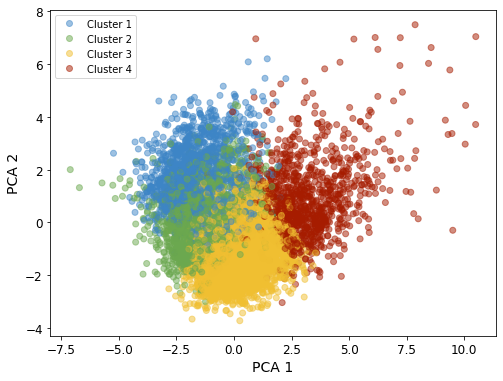

In [702]:
# Visualization with PCA and t-SNE
# PCA
from sklearn.decomposition import PCA

# pca = PCA()
# # pca.fit(km_df[manu_cols])
# # np.cumsum(pca.explained_variance_ratio_)
# pca_cols = ['age','gender', 'first_careunit_CCU', 'first_careunit_CSRU',
#        'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
#        'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 
#        'admission_type_URGENT', 'mingcs', 
#        'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 'icd_malignancy',
#        'sol_can', 'sec_can', 'lyle_can', 
#        'vp_flag', 'vent_flag', 'heartrate_mean',
#        'meanbp_mean', 'tempc_mean', 'spo2_mean', 'cvp_mean', 
#        'albumin_mean', 'bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 
#        'hematocrit_mean', 'wbc_mean', 'platelet_mean', 'lactate_mean', 'glucose_mean', 'potassium_mean',
#        'sodium_mean', 'ph', 'po2', 'pco2', 'oi']
# vis_df = pd.DataFrame(pca.fit_transform(km_df[pca_cols])).iloc[:,0:2]
# vis_df['icustay_id'], vis_df['cluster'] = mval_df['icustay_id'], km_df['cluster']

fig = plt.figure(figsize=(8, 6))

scatter = plt.scatter(vis_df.iloc[:, 0], vis_df.iloc[:, 1], c=vis_df.cluster, alpha=0.5, cmap=clist1)
clusters = ["Cluster {0}".format(i+1) for i in range(4)]
plt.legend(handles=scatter.legend_elements()[0], labels=clusters)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("PCA 1", fontsize=14)
plt.ylabel("PCA 2", fontsize=14)
# plt.scatter(vis_df.iloc[:, 0], vis_df.iloc[:, 1], c=mval_df.hosp_death, alpha=0.1)
plt.show()
fig.savefig("Pics_tables/Sfigure_5.pdf")
# todo: 3d visulization in supplementary

In [701]:
scatter.legend_elements()[0]

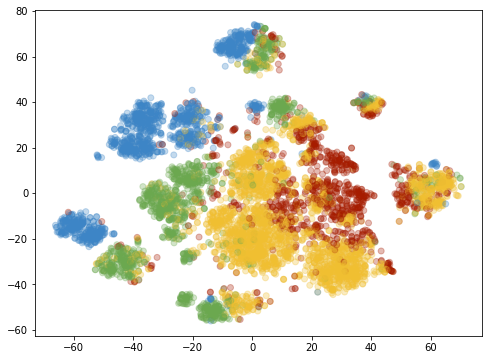

In [678]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', learning_rate=200, perplexity=50, random_state=123)
tsne_df = tsne.fit_transform(km_df[pca_cols])

tsne_df = pd.DataFrame(tsne_df, columns=['X', 'Y'])
tsne_df['cluster'] = km_df['cluster']

plt.figure(figsize=(8, 6))
plt.scatter(tsne_df.X, tsne_df.Y, c=tsne_df.cluster, alpha=0.3, cmap=clist1)
# plt.scatter(tsne_df.X, tsne_df.Y, c=mval_df.hosp_death, alpha=0.1)
plt.show()

## K-mean cluatering 3

In [211]:
mval_df = oridf_shift(mval_df_original)
mval_df, km_df = preprocess(mval_df, strategy='multivariate')

Below features have missing values, we impute by strategy of multivariate :
elixhauser_vanwalraven
heartrate_mean
meanbp_mean
tempc_mean
spo2_mean
albumin_mean
bilirubin_mean
creatinine_mean
bun_mean
glucose_mean
hematocrit_mean
lactate_mean
platelet_mean
potassium_mean
inr_mean
sodium_mean
wbc_mean
mingcs
cvp_mean
po2
pco2
oi
ph


In [212]:
# We choose K from 2 to 4, but we just desplay for 4
k = 3
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=500, random_state=0).fit(km_df)
km_df['cluster'] = kmeans.labels_
km_df['hosp_death'] = mval_df.hosp_death
# km_df.iloc[:, -2:]

In [210]:
km_df.columns

Index(['gender', 'age', 'rrt', 'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver',
       'icd_copd', 'icd_cad', 'icd_stroke', 'icd_malignancy', 'vp_flag',
       'vent_flag', 'heartrate_mean', 'meanbp_mean', 'tempc_mean', 'spo2_mean',
       'albumin_mean', 'bilirubin_mean', 'creatinine_mean', 'bun_mean',
       'glucose_mean', 'hematocrit_mean', 'lactate_mean', 'platelet_mean',
       'potassium_mean', 'inr_mean', 'sodium_mean', 'wbc_mean', 'mingcs',
       'cvp_mean', 'po2', 'pco2', 'oi', 'ph', 'sec_can', 'lyle_can', 'sol_can',
       'from_surgery', 'from_medical', 'first_careunit_CCU',
       'first_careunit_CSRU', 'first_careunit_MICU', 'first_careunit_SICU',
       'first_careunit_TSICU', 'admission_type_ELECTIVE',
       'admission_type_EMERGENCY', 'admission_type_URGENT', 'cluster',
       'hosp_death'],
      dtype='object')

In [213]:
# Order the clusters
cluster_sorted = (np.argsort([(km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0]),
            (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0]),
            (km_df[km_df.cluster == 2].hosp_death.sum() / km_df[km_df.cluster == 2].shape[0])]))
km_df['cluster'] = km_df['cluster'].apply(lambda x: list(cluster_sorted).index(x))
# Test by mortality rate
print ('The mortality of three subgroups are')
print (km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0])
print (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0])
print (km_df[km_df.cluster == 2].hosp_death.sum() / km_df[km_df.cluster == 2].shape[0])

The mortality of three subgroups are
0.07346767422334173
0.1961298786487373
0.44320297951582865


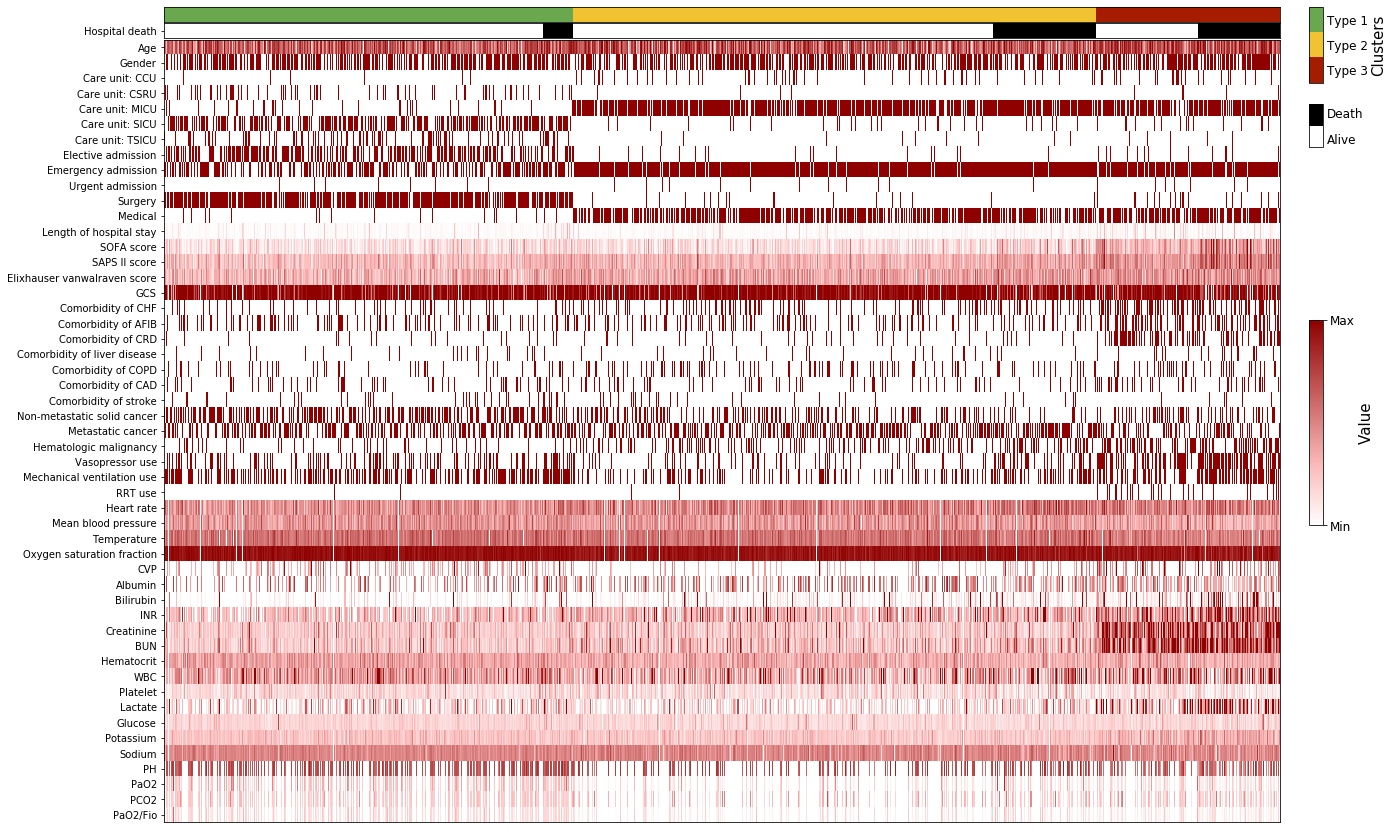

In [215]:
# Prepare for visulization
manu_cols = ['age','gender', 'first_careunit_CCU', 'first_careunit_CSRU',
       'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 'admission_type_URGENT', 
       'from_surgery', 'from_medical', 'los', 'sofa', 'sapsii', 'elixhauser_vanwalraven', 'mingcs', 
       'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 
       'sol_can', 'sec_can', 'lyle_can', 
       'vp_flag', 'vent_flag', 'rrt', 'heartrate_mean',
       'meanbp_mean', 'tempc_mean', 'spo2_mean', 'cvp_mean', 
       'albumin_mean', 'bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 
       'hematocrit_mean', 'wbc_mean', 'platelet_mean', 'lactate_mean', 'glucose_mean', 'potassium_mean',
       'sodium_mean', 'ph', 'po2', 'pco2', 'oi', 'cluster', 'hosp_death']
mval_df['cluster'] = km_df['cluster']
kmv_df = mval_df[manu_cols].sort_values(by=['cluster', 'hosp_death'])

# transforming the data for visulization
def man_outlier(x, col, df):
    if x > df[col].quantile(0.95):
        return df[col].quantile(0.95)
    else:
        return x
trs_cols = ['bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 'wbc_mean', 'lactate_mean']
for col in trs_cols:
    kmv_df[col] = mval_df[col].apply(man_outlier, col=col, df=mval_df)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
kmv_df = pd.DataFrame(min_max_scaler.fit_transform(kmv_df), columns=manu_cols)

# Visualizing the non-normalized dataset with clusters and hospital_death
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(50, 1,  wspace=0.1, hspace=0.1)

# The first two subplot: cluster and hospital death
plt.subplot(grid[0, 0])

clist1 = [(0, '#6aa84f'), (0.5, '#f1c232'), (1, '#a61c00')]
clist1 = mcolors.LinearSegmentedColormap.from_list("seg", clist1, 3)
# sm = cm.ScalarMappable(cmap=clist1)
cm.register_cmap('seg', clist1)
plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['cluster']].values.T, 
           aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])

cbaxe1 = fig.add_axes([0.92, 0.81, 0.01, 0.07])
plt.clim(-0.25, 1+0.25)
cbar1 = plt.colorbar(cax=cbaxe1, ticks=kmv_df.cluster.unique())
cbar1.ax.tick_params(length=0, labelsize=12)
cbar1.ax.set_yticklabels(["Type {0}".format(i+1) for i in range(3)])
# cbar1.ax.set_yticklabels(kmv_df.cluster.unique())
cbar1.ax.invert_yaxis()
cbar1.set_label(label='Clusters', size=15)

plt.subplot(grid[1, 0])
clist2 = [(0, 'white'), (1, 'black')]
clist2 = mcolors.LinearSegmentedColormap.from_list("wb", clist2, 2)
cm.register_cmap('wb', clist2)


plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['hosp_death']].values.T, 
           aspect='auto', cmap='wb')
plt.xticks([])
plt.yticks([0], ['Hospital death'])
cbaxe2 = fig.add_axes([0.92, 0.75, 0.01, 0.04])
plt.clim(-0.33, 1+0.33)
cbar2 = plt.colorbar(cax=cbaxe2, ticks=range(2))
cbar2.ax.tick_params(length=0, labelsize=12)
cbar2.ax.set_yticklabels(["Alive", 'Death'])

# The heatmap of clinical data
plt.subplot(grid[2:50, 0])
clist2 = [(0, '#ffffff'), (0.3, '#fbb9b9'), (1, '#8f0000')]
clist2 = mcolors.LinearSegmentedColormap.from_list("myself", clist2)

plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[manu_cols[0:-2]].values.T,
          aspect='auto', cmap=clist2)
ylabels = [
    'Age',
    'Gender',
    'Care unit: CCU',
    'Care unit: CSRU',
    'Care unit: MICU',
    'Care unit: SICU',
    'Care unit: TSICU',
    'Elective admission',
    'Emergency admission',
    'Urgent admission',
    'Surgery',
    'Medical',
    'Length of hospital stay',
    'SOFA score',
    'SAPS II score',
    'Elixhauser vanwalraven score',
    'GCS',
    'Comorbidity of CHF',
    'Comorbidity of AFIB',
    'Comorbidity of CRD',
    'Comorbidity of liver disease',
    'Comorbidity of COPD',
    'Comorbidity of CAD',
    'Comorbidity of stroke',
    'Non-metastatic solid cancer',
    'Metastatic cancer',
    'Hematologic malignancy',
    'Vasopressor use',
    'Mechanical ventilation use',
    'RRT use',
    'Heart rate',
    'Mean blood pressure',
    'Temperature',
    'Oxygen saturation fraction',
    'CVP',
    'Albumin',
    'Bilirubin',
    'INR',
    'Creatinine',
    'BUN',
    'Hematocrit',
    'WBC',
    'Platelet',
    'Lactate',
    'Glucose',
    'Potassium',
    'Sodium',
    'PH',
    'PaO2',
    'PCO2',
    'PaO2/Fio'
]
# plt.yticks([i for i in range(len(manu_cols[0:-2]))], manu_cols[0:-2])
plt.yticks([i for i in range(len(manu_cols[0:-2]))], ylabels)
plt.xticks([])
cbaxe3 = fig.add_axes([0.92, 0.4, 0.01, 0.19])
cbar3 = plt.colorbar(cax=cbaxe3)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Min', 'Max'])
cbar3.set_label(label='Value', size=15)
cbar3.ax.tick_params(labelsize=12)
plt.show()
fig.savefig('Pics_tables/SFigure_2.pdf')

## K-mean clustering 2

In [268]:
mval_df = oridf_shift(mval_df_original)
mval_df, km_df = preprocess(mval_df, strategy='multivariate')

Below features have missing values, we impute by strategy of multivariate :
elixhauser_vanwalraven
heartrate_mean
meanbp_mean
tempc_mean
spo2_mean
albumin_mean
bilirubin_mean
creatinine_mean
bun_mean
glucose_mean
hematocrit_mean
lactate_mean
platelet_mean
potassium_mean
inr_mean
sodium_mean
wbc_mean
mingcs
cvp_mean
po2
pco2
oi
ph


In [269]:
k = 2
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=500, random_state=0).fit(km_df)
km_df['cluster'] = kmeans.labels_
km_df['hosp_death'] = mval_df.hosp_death
# km_df.iloc[:, -2:]

In [270]:
# Order the clusters
cluster_sorted = (np.argsort([(km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0]),
            (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0])]))
km_df['cluster'] = km_df['cluster'].apply(lambda x: list(cluster_sorted).index(x))
# Test by mortality rate
print ('The mortality of three subgroups are')
print (km_df[km_df.cluster == 0].hosp_death.sum() / km_df[km_df.cluster == 0].shape[0])
print (km_df[km_df.cluster == 1].hosp_death.sum() / km_df[km_df.cluster == 1].shape[0])

The mortality of three subgroups are
0.07984644913627639
0.26692307692307693


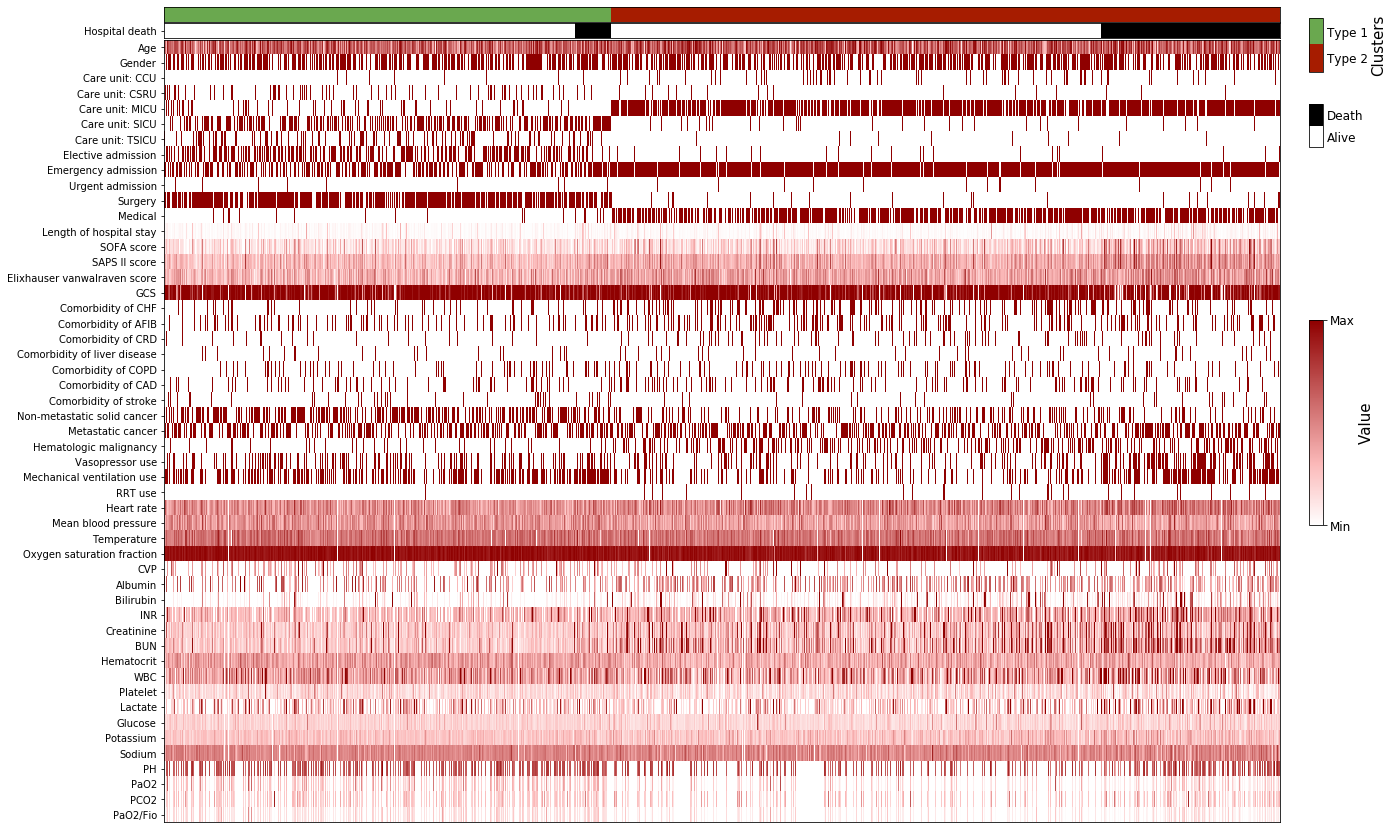

In [271]:
# Prepare for visulization
manu_cols = ['age','gender', 'first_careunit_CCU', 'first_careunit_CSRU',
       'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 'admission_type_URGENT', 
       'from_surgery', 'from_medical', 'los', 'sofa', 'sapsii', 'elixhauser_vanwalraven', 'mingcs', 
       'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 
       'sol_can', 'sec_can', 'lyle_can', 
       'vp_flag', 'vent_flag', 'rrt', 'heartrate_mean',
       'meanbp_mean', 'tempc_mean', 'spo2_mean', 'cvp_mean', 
       'albumin_mean', 'bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 
       'hematocrit_mean', 'wbc_mean', 'platelet_mean', 'lactate_mean', 'glucose_mean', 'potassium_mean',
       'sodium_mean', 'ph', 'po2', 'pco2', 'oi', 'cluster', 'hosp_death']
mval_df['cluster'] = km_df['cluster']
kmv_df = mval_df[manu_cols].sort_values(by=['cluster', 'hosp_death'])

# transforming the data for visulization
def man_outlier(x, col, df):
    if x > df[col].quantile(0.95):
        return df[col].quantile(0.95)
    else:
        return x
trs_cols = ['bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 'wbc_mean', 'lactate_mean']
for col in trs_cols:
    kmv_df[col] = mval_df[col].apply(man_outlier, col=col, df=mval_df)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
kmv_df = pd.DataFrame(min_max_scaler.fit_transform(kmv_df), columns=manu_cols)

# Visualizing the non-normalized dataset with clusters and hospital_death
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(50, 1,  wspace=0.1, hspace=0.1)

# The first two subplot: cluster and hospital death
plt.subplot(grid[0, 0])
# Create cmap of myself
clist1 = [(0, '#6aa84f'), (1, '#a61c00')]
clist1 = mcolors.LinearSegmentedColormap.from_list("seg", clist1, 2)
# sm = cm.ScalarMappable(cmap=clist1)
cm.register_cmap('seg', clist1)
plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['cluster']].values.T, 
           aspect='auto', cmap='seg')
plt.xticks([])
plt.yticks([])
cbaxe1 = fig.add_axes([0.92, 0.82, 0.01, 0.05])
plt.clim(-0.5, 1+0.5)
cbar1 = plt.colorbar(cax=cbaxe1, ticks=kmv_df.cluster.unique())
cbar1.ax.tick_params(length=0, labelsize=12)
cbar1.ax.set_yticklabels(["Type {0}".format(i+1) for i in range(2)])
# cbar1.ax.set_yticklabels(kmv_df.cluster.unique())
cbar1.ax.invert_yaxis()
cbar1.set_label(label='Clusters', size=15)

plt.subplot(grid[1, 0])
clist2 = [(0, 'white'), (1, 'black')]
clist2 = mcolors.LinearSegmentedColormap.from_list("wb", clist2, 2)
cm.register_cmap('wb', clist2)
plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[['hosp_death']].values.T, 
           aspect='auto', cmap='wb')
plt.xticks([])
plt.yticks([0], ['Hospital death'])
cbaxe2 = fig.add_axes([0.92, 0.75, 0.01, 0.04])
plt.clim(-0.5, 1+0.5)
cbar2 = plt.colorbar(cax=cbaxe2, ticks=range(2))
cbar2.ax.tick_params(length=0, labelsize=12)
cbar2.ax.set_yticklabels(["Alive", 'Death'])
# The heatmap of clinical data
plt.subplot(grid[2:50, 0])
clist2 = [(0, '#ffffff'), (0.3, '#fbb9b9'), (1, '#8f0000')]
clist2 = mcolors.LinearSegmentedColormap.from_list("myself", clist2)

plt.imshow(kmv_df.sort_values(by=['cluster', 'hosp_death'])[manu_cols[0:-2]].values.T,
          aspect='auto', cmap=clist2)
ylabels = [
    'Age',
    'Gender',
    'Care unit: CCU',
    'Care unit: CSRU',
    'Care unit: MICU',
    'Care unit: SICU',
    'Care unit: TSICU',
    'Elective admission',
    'Emergency admission',
    'Urgent admission',
    'Surgery',
    'Medical',
    'Length of hospital stay',
    'SOFA score',
    'SAPS II score',
    'Elixhauser vanwalraven score',
    'GCS',
    'Comorbidity of CHF',
    'Comorbidity of AFIB',
    'Comorbidity of CRD',
    'Comorbidity of liver disease',
    'Comorbidity of COPD',
    'Comorbidity of CAD',
    'Comorbidity of stroke',
    'Non-metastatic solid cancer',
    'Metastatic cancer',
    'Hematologic malignancy',
    'Vasopressor use',
    'Mechanical ventilation use',
    'RRT use',
    'Heart rate',
    'Mean blood pressure',
    'Temperature',
    'Oxygen saturation fraction',
    'CVP',
    'Albumin',
    'Bilirubin',
    'INR',
    'Creatinine',
    'BUN',
    'Hematocrit',
    'WBC',
    'Platelet',
    'Lactate',
    'Glucose',
    'Potassium',
    'Sodium',
    'PH',
    'PaO2',
    'PCO2',
    'PaO2/Fio'
]
# plt.yticks([i for i in range(len(manu_cols[0:-2]))], manu_cols[0:-2])
plt.yticks([i for i in range(len(manu_cols[0:-2]))], ylabels)
plt.xticks([])
cbaxe3 = fig.add_axes([0.92, 0.4, 0.01, 0.19])
cbar3 = plt.colorbar(cax=cbaxe3)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Min', 'Max'])
cbar3.set_label(label='Value', size=15)
cbar3.ax.tick_params(labelsize=12)
plt.show()
fig.savefig('Pics_tables/SFigure_3.pdf')

## Charactoristics of different clusters

In [226]:
mval_df.columns

Index(['subject_id', 'icustay_id', 'gender', 'age', 'los', 'rrt', 'hosp_death',
       'd28_death', 'sofa', 'sapsii', 'hadm_id', 'icd_chf', 'icd_afib',
       'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke',
       'icd_malignancy', 'elixhauser_vanwalraven', 'vp_flag', 'vent_flag',
       'heartrate_mean', 'meanbp_mean', 'tempc_mean', 'spo2_mean',
       'albumin_mean', 'bilirubin_mean', 'creatinine_mean', 'bun_mean',
       'glucose_mean', 'hematocrit_mean', 'lactate_mean', 'platelet_mean',
       'potassium_mean', 'inr_mean', 'sodium_mean', 'wbc_mean', 'mingcs',
       'cvp_mean', 'po2', 'pco2', 'oi', 'ph', 'rk', 'sec_can', 'lyle_can',
       'sol_can', 'from_surgery', 'from_medical', 'first_careunit_CCU',
       'first_careunit_CSRU', 'first_careunit_MICU', 'first_careunit_SICU',
       'first_careunit_TSICU', 'admission_type_ELECTIVE',
       'admission_type_EMERGENCY', 'admission_type_URGENT', 'cluster'],
      dtype='object')

In [227]:
# The charactoristics of cancer patients from different subtypes
from tableone import TableOne
display_cols = ['age','gender', 'first_careunit', 
       'admission_type', 'from_surgery', 'from_medical',
       'sofa', 'sapsii', 'elixhauser_vanwalraven', 'mingcs', 
       'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 
       'sol_can', 'sec_can', 'lyle_can', 
       'vp_flag', 'vent_flag', 'rrt', 'heartrate_mean',
       'meanbp_mean', 'tempc_mean', 'spo2_mean', 'cvp_mean', 
       'albumin_mean', 'bilirubin_mean', 'inr_mean', 'creatinine_mean', 'bun_mean', 
       'hematocrit_mean', 'wbc_mean', 'platelet_mean', 'lactate_mean', 'glucose_mean', 'potassium_mean',
       'sodium_mean', 'ph', 'po2', 'pco2', 'oi', 'cluster', 'los', 'hosp_death'] 
clusters_df = oridf_shift(mval_df_original).assign(cluster=km_df.cluster)[display_cols]
clusters_df['age'] = clusters_df.age.astype(int)
cate_cols = ['gender', 'vp_flag', 'admission_type', 'first_careunit', 'from_surgery', 'from_medical', 
             'icd_chf', 'icd_afib', 'icd_renal', 'icd_liver', 'icd_copd', 'icd_cad', 'icd_stroke', 
             'sol_can', 'sec_can', 'lyle_can',  'vent_flag', 'rrt', 'hosp_death']
TableOne(clusters_df, columns=display_cols, categorical=cate_cols,
                   groupby=['cluster'], pval=True).to_excel('Tableone_clusters.xlsx')

## Outcoms of different clusters

### MIMIC

In [257]:
# hospital mortality
k = 4
clusters_num = [mval_df[mval_df.cluster==i].shape[0] for i in range(k)]
clusters_mortality = [mval_df[mval_df.cluster == i].hosp_death.sum() / clusters_num[i] for i in range(k)]
saps_seq_mortality = []
for i in range(k):
    if i == 0:
        saps_seq_mortality.append(mval_df.sort_values(by='sapsii').iloc[:clusters_num[i],:].hosp_death.sum() / clusters_num[i])
    else:
        saps_seq_mortality.append(mval_df.sort_values(by='sapsii').iloc[np.sum(np.array(clusters_num)[0:i]):np.sum(np.array(clusters_num)[0:i+1]),:].hosp_death.sum() / clusters_num[i])
saps_seq_mortality

[0.04772902232486528,
 0.08529411764705883,
 0.20118137595552468,
 0.5082644628099173]

In [258]:
# Comparing cluster-mortality and sapsii sequence mortality
from scipy.stats import beta
clusters_mort = pd.DataFrame({'clusters_num': [mval_df[mval_df.cluster==i].shape[0] for i in range(k)],
                             'clusters_death': [mval_df[mval_df.cluster == i].hosp_death.sum() for i in range(k)]})
saps_seq_death = []
for i in range(k):
    if i == 0:
        saps_seq_death.append(mval_df.sort_values(by='sapsii').iloc[:clusters_mort.clusters_num[i],:].hosp_death.sum())
    else:
        saps_seq_death.append(mval_df.sort_values(by='sapsii').iloc[clusters_mort.clusters_num[0:i].sum():clusters_mort.clusters_num[0:i+1].sum(),:].hosp_death.sum())
clusters_mort['saps_seq_death'] = saps_seq_death
clusters_mort['clusters_morate'] = clusters_mort.apply(lambda x: x.clusters_death / x.clusters_num, axis=1)
clusters_mort['saps_seq_morate'] = clusters_mort.apply(lambda x: x.saps_seq_death / x.clusters_num, axis=1)
clusters_mort['cluster_95up'] = clusters_mort.apply(lambda x: beta.interval(0.95, x['clusters_death'], x['clusters_num']-x['clusters_death']+1)[0], axis=1)
clusters_mort['cluster_95down'] = clusters_mort.apply(lambda x: beta.interval(0.95, x['clusters_death'], x['clusters_num']-x['clusters_death']+1)[1], axis=1)
clusters_mort['saps_seq_95up'] = clusters_mort.apply(lambda x: beta.interval(0.95, x['saps_seq_death'], x['clusters_num']-x['saps_seq_death']+1)[0], axis=1)
clusters_mort['saps_seq_95down'] = clusters_mort.apply(lambda x: beta.interval(0.95, x['saps_seq_death'], x['clusters_num']-x['saps_seq_death']+1)[1], axis=1)

In [259]:
# Comparing cluster sapsii and sequence-based sapsii
cluster_sapsii = pd.DataFrame({'cluster_median': [mval_df[mval_df.cluster==i].sapsii.median() for i in range(k)],
                               'cluster_25': [mval_df[mval_df.cluster==i].sapsii.quantile(0.25) for i in range(k)],
                               'cluster_75': [mval_df[mval_df.cluster==i].sapsii.quantile(0.75) for i in range(k)]})

sapsii_seq = pd.DataFrame()
for i in range(k):
    if i == 0:
        sapsii_seq[str(i)] = mval_df.sort_values(by='sapsii').iloc[:clusters_mort.clusters_num[i],:].sapsii.quantile([0.25, 0.5, 0.75])
    else:
        sapsii_seq[str(i)] = mval_df.sort_values(by='sapsii').iloc[clusters_mort.clusters_num[0:i].sum():clusters_mort.clusters_num[0:i+1].sum(),:].sapsii.quantile([0.25, 0.5, 0.75])

sapsii_seq = sapsii_seq.T.reset_index(drop=True)
cluster_sapsii = pd.concat([cluster_sapsii,sapsii_seq], axis=1).rename(columns={0.25: 'saps_25', 0.5: 'saps_median', 0.75: 'saps_75'})
cluster_sapsii


,cluster_median,cluster_25,cluster_75,saps_25,saps_median,saps_75
0,31.0,23.0,39.0,19.5,23.0,26.0
1,37.0,30.0,45.0,30.0,32.0,34.0
2,38.5,31.0,47.0,39.0,43.0,48.0
3,56.0,47.0,67.0,58.0,63.0,71.0


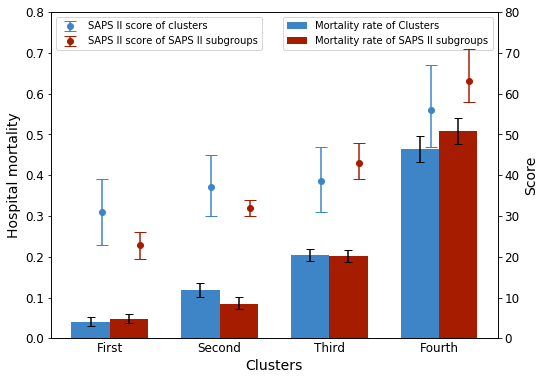

In [263]:
# visualize the mortality of clusters comparing to sapsii sequnce
fig, ax1 = plt.subplots(figsize=(8,6))


width = 0.35

ax1.bar(clusters_mort.index - width/2 - 0.1, 
        clusters_mort.clusters_morate, 
        width, 
        yerr=[clusters_mort.clusters_morate - clusters_mort.cluster_95up, 
              clusters_mort.cluster_95down - clusters_mort.clusters_morate], 
        capsize=4, label='Mortality rate of Clusters', color='#3d85c6')
ax1.bar(clusters_mort.index + width/2 - 0.1, 
        clusters_mort.saps_seq_morate, 
        width, 
        yerr=[clusters_mort.saps_seq_morate - clusters_mort.saps_seq_95up, 
              clusters_mort.saps_seq_95down - clusters_mort.saps_seq_morate], 
        capsize=4, label='Mortality rate of SAPS II subgroups', color='#a61c00')
ax1.set_xticks(clusters_mort.index - 0.1)
ax1.set_ylim(0,0.8)
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', length=0)
ax1.set_xticklabels(["First", "Second", "Third", "Fourth"])
ax1.set_ylabel("Hospital mortality", fontsize="14")
ax1.set_xlabel("Clusters", fontsize="14")
ax1.legend()

ax2 = ax1.twinx()
ax2.errorbar(cluster_sapsii.index - width/2, cluster_sapsii.cluster_median, 
             yerr=[cluster_sapsii.cluster_median - cluster_sapsii.cluster_25, 
                   cluster_sapsii.cluster_75 - cluster_sapsii.cluster_median],
             fmt='o', capsize=6, linestyle='', label='SAPS II score of clusters', color='#3d85c6')
ax2.errorbar(cluster_sapsii.index + width/2, cluster_sapsii.saps_median, 
             yerr=[cluster_sapsii.saps_median - cluster_sapsii.saps_25, 
                   cluster_sapsii.saps_75 - cluster_sapsii.saps_median],
             fmt='o', capsize=6, linestyle='', label='SAPS II score of SAPS II subgroups', color='#a61c00')
ax2.set_ylim(0,80)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper left')
ax2.set_ylabel("Score", fontsize="14")
plt.show()
fig.savefig("Pics_tables/Figure_3.pdf")

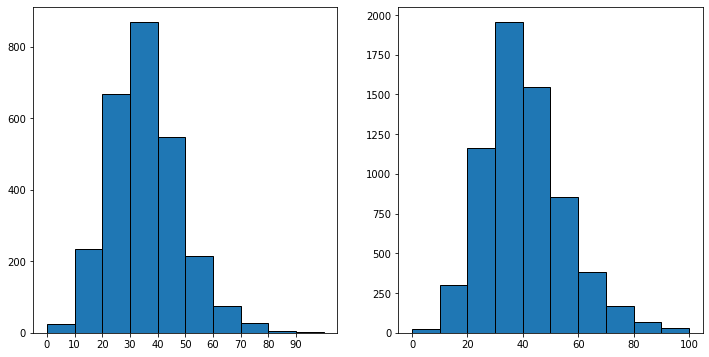

In [482]:
# distribution of cluster 0 and 1 comparing the whole population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(mval_df[mval_df.cluster<=1].sapsii, edgecolor='black', bins=range(0, 110, 10))
ax1.set_xticks(range(0, 100, 10))
ax2.hist(mval_df.sapsii, edgecolor='black', bins=range(0, 110, 10))
plt.show()

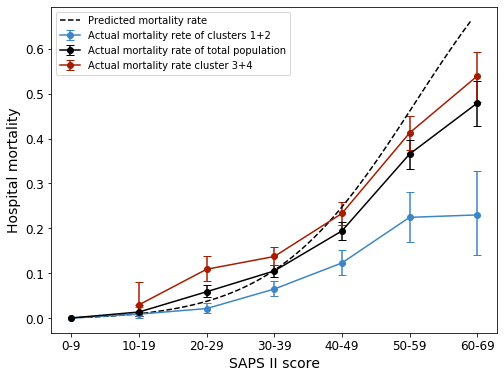

In [286]:
# The moratality rate in diffrent SAPSII subgroups
from scipy.stats import beta
death_sapsii = pd.DataFrame(np.arange(0, 70, 10), columns=['sapsii'])
cluster23 = mval_df[mval_df.cluster > 1]

def deathnum(mval_df, x, cluster='surgery'):
    if cluster == 'surgery':
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10) & (mval_df.cluster <= 1)].hosp_death.sum()
    elif cluster == 'non-surgery':
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10) & (mval_df.cluster > 1)].hosp_death.sum()   
    else:
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10)].hosp_death.sum()
def totalnum(mval_df, x, cluster='surgery'):
    if cluster == 'surgery':
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10) & (mval_df.cluster <= 1)].shape[0]
    elif cluster == 'non-surgery':
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10) & (mval_df.cluster > 1)].shape[0]   
    else:
        return mval_df[(mval_df.sapsii >= x) & (mval_df.sapsii < x+10)].shape[0]
    

death_sapsii['cluster1'] = death_sapsii['sapsii'].apply(lambda x: deathnum(mval_df, x, cluster='surgery')/totalnum(mval_df, x, cluster='surgery'))
death_sapsii['saps_line'] = death_sapsii['sapsii'].apply(lambda x: deathnum(mval_df, x, cluster='none')/totalnum(mval_df, x, cluster='none'))
death_sapsii['cluster23'] = death_sapsii['sapsii'].apply(lambda x: deathnum(mval_df, x, cluster='non-surgery')/totalnum(mval_df, x, cluster='non-surgery'))

death_sapsii['cluster1_95up'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='surgery'), totalnum(mval_df, x, cluster='surgery') - deathnum(mval_df, x, cluster='surgery') + 1)[0])
death_sapsii['cluster1_95down'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='surgery'), totalnum(mval_df, x, cluster='surgery') - deathnum(mval_df, x, cluster='surgery') + 1)[1])
death_sapsii['saps_line_95up'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='none'), totalnum(mval_df, x, cluster='none') - deathnum(mval_df, x, cluster='none') + 1)[0])
death_sapsii['saps_line_95down'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='none'), totalnum(mval_df, x, cluster='none') - deathnum(mval_df, x, cluster='none') + 1)[1])
death_sapsii['cluster23_95up'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='non-surgery'), totalnum(mval_df, x, cluster='non-surgery') - deathnum(mval_df, x, cluster='non-surgery') + 1)[0])
death_sapsii['cluster23_95down'] = death_sapsii['sapsii'].apply(lambda x: beta.interval(0.95, deathnum(mval_df, x, cluster='non-surgery'), totalnum(mval_df, x, cluster='non-surgery') - deathnum(mval_df, x, cluster='non-surgery') + 1)[1])

def sapstosmr(score):
    logit = -7.7631 + 0.0737 * score + 0.9971 * np.log(score+1)
    return np.exp(logit)/ (1+np.exp(logit))

saps_smr = pd.DataFrame(np.arange(0, 60, 1), columns=['sapsii'])
saps_smr['smr'] = saps_smr.apply(sapstosmr)


fig = plt.figure(figsize=(8,6))
# plt.plot(death_sapsii.sapsii, death_sapsii.cluster1, label='cluster1')
# plt.plot(death_sapsii.sapsii, death_sapsii.saps_line, label='saps_line')
# plt.plot(death_sapsii.sapsii, death_sapsii.cluster23, label='cluster23')
plt.errorbar(death_sapsii.sapsii, death_sapsii.cluster1, yerr=[death_sapsii.cluster1 - death_sapsii.cluster1_95up, death_sapsii.cluster1_95down - death_sapsii.cluster1], capsize=4, label='Actual mortality rete of clusters 1+2', color='#3d85c6', fmt='o', linestyle='-')
plt.errorbar(death_sapsii.sapsii, death_sapsii.saps_line, yerr=[death_sapsii.saps_line - death_sapsii.saps_line_95up, death_sapsii.saps_line_95down - death_sapsii.saps_line], capsize=4, label='Actual mortality rate of total population', color='black', fmt='o', linestyle='-')
plt.errorbar(death_sapsii.sapsii, death_sapsii.cluster23, yerr=[death_sapsii.cluster23 - death_sapsii.cluster23_95up, death_sapsii.cluster23_95down - death_sapsii.cluster23], capsize=4, label='Actual mortality rate cluster 3+4', color='#a61c00', fmt='o', linestyle='-')
plt.plot(saps_smr.sapsii, saps_smr.smr, label='Predicted mortality rate', color='black', linestyle='--')

plt.xticks(range(0, 70, 10), ['{0}-{1}'.format(i, i+9) for i in range(0, 70, 10)], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("SAPS II score", fontsize=14)
plt.ylabel("Hospital mortality", fontsize=14)
plt.legend()
plt.show()
fig.savefig("Pics_tables/Figure_4.pdf")

In [275]:
death_sapsii

,sapsii,cluster1,saps_line,cluster23,cluster1_95up,cluster1_95down,saps_line_95up,saps_line_95down,cluster23_95up,cluster23_95down
0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.013289,0.013289,NaN,0.003632,0.028849,0.003632,0.028849,NaN,NaN
2,20,0.058469,0.058469,NaN,0.045686,0.072588,0.045686,0.072588,NaN,NaN
3,30,0.104859,0.104859,NaN,0.091623,0.118754,0.091623,0.118754,NaN,NaN
4,40,0.194049,0.194049,NaN,0.174608,0.213989,0.174608,0.213989,NaN,NaN
5,50,0.365340,0.365340,NaN,0.332971,0.397452,0.332971,0.397452,NaN,NaN
6,60,0.478947,0.478947,NaN,0.427739,0.527864,0.427739,0.527864,NaN,NaN


In [730]:
# Hosmer-Lemeshow C statistic

HL_12 = eicu_can_pid[eicu_can_pid['surgery'] == 1]
HL_34 = eicu_can_pid[eicu_can_pid['surgery'] == 0]

In [752]:
from scipy.stats import chi2
HL_12['apache_decile'] = pd.qcut(HL_12['apachescore'], 10)
print (HL_12['mortality'].groupby(HL_12.apache_decile).sum())
print (HL_12['phm'].groupby(HL_12.apache_decile).sum())
chi2_12 = np.sum((HL_12['mortality'].groupby(HL_12.apache_decile).sum() - HL_12['phm'].groupby(HL_12.apache_decile).sum())**2\
/HL_12['phm'].groupby(HL_12.apache_decile).sum() + ((HL_12['mortality'].groupby(HL_12.apache_decile).count()-\
                                                   HL_12['mortality'].groupby(HL_12.apache_decile).sum()) -\
                (HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum()))**2/\
                (HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum()))
pval_12 = 1 - chi2.cdf(chi2_12, 8)
print (chi2_12, pval_12)


apache_decile
(7.999, 26.0]     2
(26.0, 31.0]      3
(31.0, 37.0]      0
(37.0, 41.0]      1
(41.0, 45.0]      2
(45.0, 49.0]      1
(49.0, 55.0]      2
(55.0, 64.0]     10
(64.0, 75.0]     12
(75.0, 151.0]    27
Name: mortality, dtype: int64
apache_decile
(7.999, 26.0]     1.282999
(26.0, 31.0]      2.012622
(31.0, 37.0]      3.276325
(37.0, 41.0]      3.615064
(41.0, 45.0]      5.453988
(45.0, 49.0]      5.508739
(49.0, 55.0]      7.003265
(55.0, 64.0]     13.120601
(64.0, 75.0]     14.664759
(75.0, 151.0]    42.191272
Name: phm, dtype: float64
25.252609814175393 0.00140846839594988


/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [751]:
# ((HL_12['mortality'].groupby(HL_12.apache_decile).count()-\
#                                                    HL_12['mortality'].groupby(HL_12.apache_decile).sum()) -\
#                 (HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum()))**2/\
(HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum())

apache_decile
(7.999, 26.0]    148.717001
(26.0, 31.0]     131.987378
(31.0, 37.0]     166.723675
(37.0, 41.0]     122.384936
(41.0, 45.0]     149.546012
(45.0, 49.0]     131.491261
(49.0, 55.0]     115.996735
(55.0, 64.0]     137.879399
(64.0, 75.0]     111.335241
(75.0, 151.0]     98.808728
Name: phm, dtype: float64

In [742]:
HL_34['apache_decile'] = pd.qcut(HL_34['apachescore'], 10)
print (HL_34['mortality'].groupby(HL_34.apache_decile).sum())
print (HL_34['phm'].groupby(HL_34.apache_decile).sum())
chi2_34 = np.sum((HL_34['mortality'].groupby(HL_34.apache_decile).sum() - HL_34['phm'].groupby(HL_34.apache_decile).sum())**2\
/HL_34['phm'].groupby(HL_34.apache_decile).sum())
pval_34 = 1 - chi2.cdf(chi2_34, 8)
print (chi2_34, pval_34)

apache_decile
(3.999, 32.0]     24
(32.0, 39.0]      30
(39.0, 46.0]      35
(46.0, 51.0]      41
(51.0, 57.0]      68
(57.0, 64.0]      91
(64.0, 71.0]     104
(71.0, 80.0]     116
(80.0, 97.0]     195
(97.0, 195.0]    291
Name: mortality, dtype: int64
apache_decile
(3.999, 32.0]     12.476086
(32.0, 39.0]      20.420968
(39.0, 46.0]      35.248480
(46.0, 51.0]      38.898197
(51.0, 57.0]      67.227966
(57.0, 64.0]      91.695688
(64.0, 71.0]     102.653368
(71.0, 80.0]     132.254775
(80.0, 97.0]     217.844320
(97.0, 195.0]    358.755793
Name: phm, dtype: float64
32.47480779840636 7.655617112112267e-05


/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


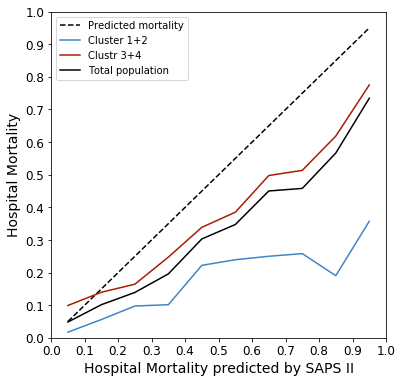

In [146]:
# calibration plot
risk_seq = pd.DataFrame(np.arange(0.05, 1.05, 0.1), columns=['risk'])
saps_pred = mval_df.sapsii.apply(sapstosmr)
risk_seq['total'] = risk_seq.risk.apply(lambda x: mval_df[(saps_pred >= x-0.05) & (saps_pred < x+0.05)].hosp_death.sum() /
                                       mval_df[(saps_pred >= x-0.05) & (saps_pred < x+0.05)].shape[0])
risk_seq['surgery'] = risk_seq.risk.apply(lambda x: mval_df[(saps_pred >= x-0.05) & 
                                                                 (saps_pred < x+0.05) &
                                                                (mval_df.cluster < 2)].hosp_death.sum() /
                                       mval_df[(saps_pred >= x-0.05) & 
                                                    (saps_pred < x+0.05) &
                                                   (mval_df.cluster < 2)].shape[0])
risk_seq['non_surgery'] = risk_seq.risk.apply(lambda x: mval_df[(saps_pred >= x-0.05) & 
                                                                     (saps_pred < x+0.05) &
                                                                    (mval_df.cluster > 1)].hosp_death.sum() /
                                       mval_df[(saps_pred >= x-0.05) & 
                                                    (saps_pred < x+0.05) &
                                                   (mval_df.cluster > 1)].shape[0])
fig = plt.figure(figsize=(6,6))
plt.plot(risk_seq.risk, risk_seq.risk, label='Predicted mortality', linestyle='--', color='black')
plt.plot(risk_seq.risk, risk_seq.surgery, label='Cluster 1+2', color='#3d85c6')
plt.plot(risk_seq.risk, risk_seq.non_surgery, label='Clustr 3+4', color='#a61c00')
plt.plot(risk_seq.risk, risk_seq.total, label='Total population', color='black')
plt.ylim(0,1)
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.xlabel("Hospital Mortality predicted by SAPS II", fontsize=14)
plt.ylabel("Hospital Mortality", fontsize=14)
plt.legend()
plt.show()
# fig.savefig("Pics_tables/Figure_7.pdf")


# plt.hist(eicu_can_pid.sapsii.apply(sapstosmr))

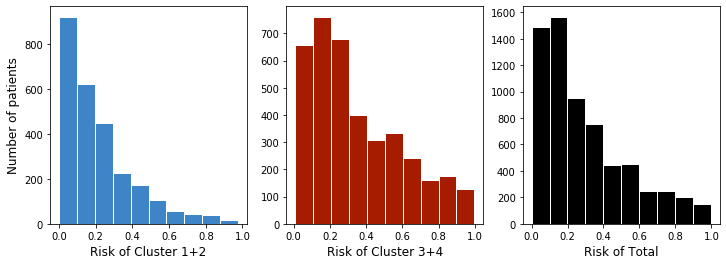

In [144]:
# distribution of three
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(mval_df[mval_df.cluster < 2].sapsii.apply(sapstosmr), color='#3d85c6', edgecolor='white')
ax1.set_xlabel("Risk of Cluster 1+2", fontsize=12)
ax1.set_ylabel("Number of patients", fontsize=12)
ax2.hist(mval_df[mval_df.cluster > 1].sapsii.apply(sapstosmr), color='#a61c00', edgecolor='white')
ax2.set_xlabel("Risk of Cluster 3+4", fontsize=12)
ax3.hist(mval_df.sapsii.apply(sapstosmr), color='black', edgecolor='white')
ax3.set_xlabel("Risk of Total", fontsize=12)
plt.show()
# fig.savefig("Pics_tables/SFigure_5.pdf")

### EICU

In [9]:
# Extract data from EICU
eicu_can_sql = """
set search_path to eicu_crd;
select distinct dg.patientunitstayid as pid,
aps.apachescore, case when aps.predictedhospitalmortality = '-1' then null else aps.predictedhospitalmortality end as phm,
case when lower(pt.unitadmitsource) like 'operating room' then 1 else 0 end as surgery,
case when lower(pt.hospitaldischargelocation) like 'death' then 1 else 0 end as mortality,
ss.SAPSII
from diagnosis dg left join apachepatientresult aps on dg.patientunitstayid = aps.patientunitstayid 
left join patient pt on dg.patientunitstayid = pt.patientunitstayid
left join sapsiiscore ss on dg.patientunitstayid = ss.patientunitstayid
where aps.apacheversion = 'IV'
and aps.apachescore >= 0
and aps.actualiculos >= 4/24
and dg.icd9code like any('{%s}');
""" % cancodes
eicu_can_pid = extract(eicu_args, eicu_can_sql)
eicu_can_pid['phm'] = pd.to_numeric(eicu_can_pid.phm)
eicu_can_pid['sapspred'] = eicu_can_pid.sapsii.apply(sapstosmr)
print (eicu_can_pid.shape)

(7351, 7)


In [10]:
surgery_sapsii = pd.DataFrame(np.arange(0, 80, 10), columns=['sapsii_seq'])
no_surgery = eicu_can_pid[eicu_can_pid.surgery != 0]

def deathnum(df, x, cluster='surgery', pred=False):
    if pred == False:
        if cluster == 'surgery':
            return df[(df.sapsii>= x) & (df.sapsii < x+10) & (df.surgery == 1)].mortality.sum()
        elif cluster == 'non-surgery':
            return df[(df.sapsii >= x) & (df.sapsii < x+10) & (df.surgery != 1)].mortality.sum()   
        else:
            return df[(df.sapsii >= x) & (df.sapsii < x+10)].mortality.sum()
    else:
        if cluster == 'surgery':
            return df[(df.sapsii>= x) & (df.sapsii < x+10) & (df.surgery == 1)].phm.sum()
        elif cluster == 'non-surgery':
            return df[(df.sapsii >= x) & (df.sapsii < x+10) & (df.surgery != 1)].phm.sum()   
        else:
            return df[(df.sapsii>= x) & (df.sapsii < x+10)].phm.sum()
    
def totalnum(df, x, cluster='surgery'):
    if cluster == 'surgery':
        return df[(df.sapsii >= x) & (df.sapsii < x+10) & (df.surgery == 1)].shape[0]
    elif cluster == 'non-surgery':
        return df[(df.sapsii >= x) & (df.sapsii < x+10) & (df.surgery != 1)].shape[0]   
    else:
        return df[(df.sapsii >= x) & (df.sapsii < x+10)].shape[0] 


surgery_sapsii['surgery'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='surgery') / 
                                                           totalnum(eicu_can_pid, x, cluster='surgery'))
surgery_sapsii['non_surgery'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='non-surgery') / 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery'))
surgery_sapsii['total'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='none') / 
                                                           totalnum(eicu_can_pid, x, cluster='none'))
surgery_sapsii['pred_surgery'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='surgery', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='surgery'))
surgery_sapsii['pred_nonsurgery'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery'))
surgery_sapsii['pred'] = surgery_sapsii.sapsii_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='none', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='none'))

surgery_sapsii['surgery_95up'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery') + 1) [0])
surgery_sapsii['surgery_95down'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery') + 1) [1])
surgery_sapsii['nonsurgery_95up'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery') + 1) [0])
surgery_sapsii['nonsurgery_95down'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery') + 1) [1])
surgery_sapsii['total_95up'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none'), 
                                                           totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none') + 1) [0])
surgery_sapsii['total_95down'] = surgery_sapsii.sapsii_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none'), 
                                                           totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none') + 1) [1])

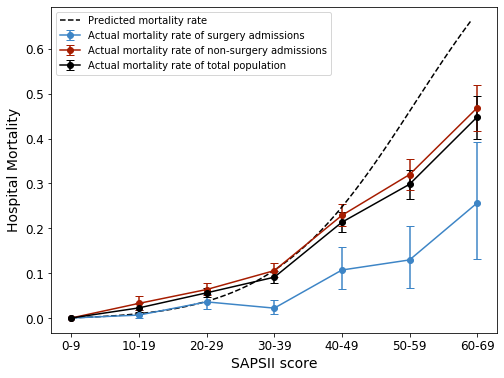

In [11]:
# Visualize mortality rate from different sapsii segment
fig = plt.figure(figsize=(8,6))
surgery_sapsii = surgery_sapsii[surgery_sapsii.sapsii_seq < 70]
plt.errorbar(surgery_sapsii.sapsii_seq, surgery_sapsii.surgery, 
             yerr=[surgery_sapsii.surgery-surgery_sapsii.surgery_95up,
                  surgery_sapsii.surgery_95down-surgery_sapsii.surgery],
            capsize=4, linestyle='-', fmt='o', label='Actual mortality rate of surgery admissions', color='#3d85c6')
plt.errorbar(surgery_sapsii.sapsii_seq, surgery_sapsii.non_surgery, 
             yerr=[surgery_sapsii.non_surgery-surgery_sapsii.nonsurgery_95up,
                  surgery_sapsii.nonsurgery_95down-surgery_sapsii.non_surgery],
            capsize=4, linestyle='-', fmt='o', label='Actual mortality rate of non-surgery admissions', color='#a61c00')
plt.errorbar(surgery_sapsii.sapsii_seq, surgery_sapsii.total, 
             yerr=[surgery_sapsii.total-surgery_sapsii.total_95up,
                  surgery_sapsii.total_95down-surgery_sapsii.total],
            capsize=4, linestyle='-', fmt='o', label='Actual mortality rate of total population', color='black')
saps_smr = pd.DataFrame(np.arange(0, 60, 1), columns=['sapsii'])
saps_smr['smr'] = saps_smr.apply(sapstosmr)
# plt.bar(surgery_sapsii.sapsii_seq-width, surgery_sapsii.pred_surgery, width, 
#         label='Predicted mortality rate of surgery admissions', color='#3d85c6')
# plt.bar(surgery_sapsii.sapsii_seq+width, surgery_sapsii.pred_nonsurgery, width,
#        label='Predicted mortality rate of non-surgery admissions', color='#a61c00')
# plt.xticks(range(0, 80, 10), ["{0}-{1}".format(i, i+9) for i in range(0, 80, 10)], fontsize=12)
plt.plot(saps_smr.sapsii, saps_smr.smr, label='Predicted mortality rate', color='black', linestyle='--') 
plt.xticks(range(0, 70, 10), ["{0}-{1}".format(i, i+9) for i in range(0, 80, 10)], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Hospital Mortality", fontsize=14)
plt.xlabel("SAPSII score", fontsize=14)
plt.legend()
plt.show()
fig.savefig("Pics_tables/Figure_6.pdf")

In [8]:
def sapstosmr(score):
    logit = -7.7631 + 0.0737 * score + 0.9971 * np.log(score+1)
    return np.exp(logit)/ (1+np.exp(logit))

In [12]:
# mortality rate of different apache segment
eicu_can_pid = eicu_can_pid.dropna()
surgery_apache = pd.DataFrame(np.arange(0, 80, 10), columns=['apache_seq'])
no_surgery = eicu_can_pid[eicu_can_pid.surgery != 0]

def deathnum(df, x, cluster='surgery', pred=False):
    if pred == False:
        if cluster == 'surgery':
            return df[(df.apachescore>= x) & (df.apachescore < x+10) & (df.surgery == 1)].mortality.sum()
        elif cluster == 'non-surgery':
            return df[(df.apachescore >= x) & (df.apachescore < x+10) & (df.surgery != 1)].mortality.sum()   
        else:
            return df[(df.apachescore >= x) & (df.apachescore < x+10)].mortality.sum()
    else:
        if cluster == 'surgery':
            return df[(df.apachescore>= x) & (df.apachescore < x+10) & (df.surgery == 1)].phm.sum()
        elif cluster == 'non-surgery':
            return df[(df.apachescore >= x) & (df.apachescore < x+10) & (df.surgery != 1)].phm.sum()   
        else:
            return df[(df.apachescore>= x) & (df.apachescore < x+10)].phm.sum()
    
def totalnum(df, x, cluster='surgery'):
    if cluster == 'surgery':
        return df[(df.apachescore >= x) & (df.apachescore < x+10) & (df.surgery == 1)].shape[0]
    elif cluster == 'non-surgery':
        return df[(df.apachescore >= x) & (df.apachescore < x+10) & (df.surgery != 1)].shape[0]   
    else:
        return df[(df.apachescore >= x) & (df.apachescore < x+10)].shape[0] 


surgery_apache['surgery'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='surgery') / 
                                                           totalnum(eicu_can_pid, x, cluster='surgery'))
surgery_apache['non_surgery'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='non-surgery') / 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery'))
surgery_apache['total'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='none') / 
                                                           totalnum(eicu_can_pid, x, cluster='none'))
surgery_apache['pred_surgery'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='surgery', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='surgery'))
surgery_apache['pred_nonsurgery'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery'))
surgery_apache['pred'] = surgery_apache.apache_seq.apply(lambda x: deathnum(eicu_can_pid, x, cluster='none', pred=True) / 
                                                           totalnum(eicu_can_pid, x, cluster='none'))

surgery_apache['surgery_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery') + 1) [0])
surgery_apache['surgery_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery') + 1) [1])
surgery_apache['nonsurgery_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery') + 1) [0])
surgery_apache['nonsurgery_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery'), 
                                                           totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery') + 1) [1])
surgery_apache['total_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none'), 
                                                           totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none') + 1) [0])
surgery_apache['total_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none'), 
                                                           totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none') + 1) [1])
# surgery_apache['pred_surgery_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery', pred=True) + 1) [0])
# surgery_apache['pred_surgery_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='surgery', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='surgery') - deathnum(eicu_can_pid, x, cluster='surgery', pred=True) + 1) [1])
# surgery_apache['pred_nonsurgery_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True) + 1) [0])
# surgery_apache['pred_nonsurgery_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='non-surgery') - deathnum(eicu_can_pid, x, cluster='non-surgery', pred=True) + 1) [1])
# surgery_apache['pred_95up'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none', pred=True) + 1) [0])
# surgery_apache['pred_95down'] = surgery_apache.apache_seq.apply(lambda x: beta.interval(0.95, deathnum(eicu_can_pid, x, cluster='none', pred=True), 
#                                                            totalnum(eicu_can_pid, x, cluster='none') - deathnum(eicu_can_pid, x, cluster='none', pred=True) + 1) [1])

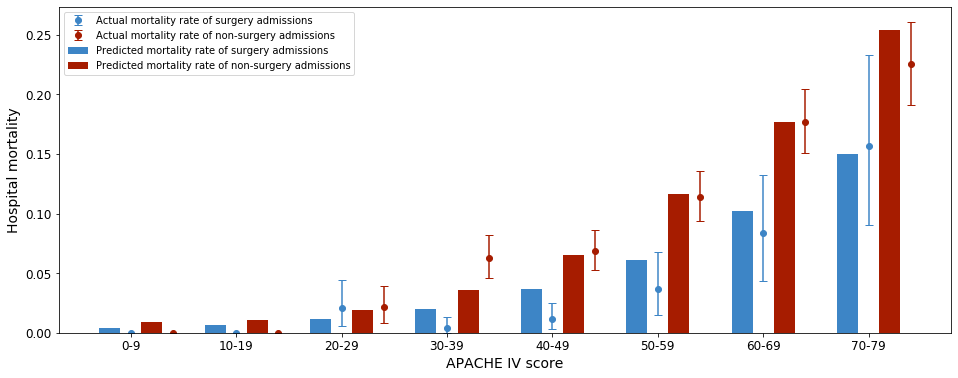

In [13]:
# Visualize mortality rate from different apache segment
fig = plt.figure(figsize=(16,6))
width = 2
plt.errorbar(surgery_apache.apache_seq, surgery_apache.surgery, 
             yerr=[surgery_apache.surgery-surgery_apache.surgery_95up,
                  surgery_apache.surgery_95down-surgery_apache.surgery],
            capsize=4, linestyle='', fmt='o', label='Actual mortality rate of surgery admissions', color='#3d85c6')
plt.errorbar(surgery_apache.apache_seq + width*2, surgery_apache.non_surgery, 
             yerr=[surgery_apache.non_surgery-surgery_apache.nonsurgery_95up,
                  surgery_apache.nonsurgery_95down-surgery_apache.non_surgery],
            capsize=4, linestyle='', fmt='o', label='Actual mortality rate of non-surgery admissions', color='#a61c00')
plt.bar(surgery_apache.apache_seq-width, surgery_apache.pred_surgery, width, 
        label='Predicted mortality rate of surgery admissions', color='#3d85c6')
plt.bar(surgery_apache.apache_seq+width, surgery_apache.pred_nonsurgery, width,
       label='Predicted mortality rate of non-surgery admissions', color='#a61c00')
plt.xticks(range(0, 80, 10), ["{0}-{1}".format(i, i+9) for i in range(0, 80, 10)], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Hospital mortality", fontsize=14)
plt.xlabel("APACHE IV score", fontsize=14)
plt.legend()
plt.show()
fig.savefig("Pics_tables/Figure_5.pdf")

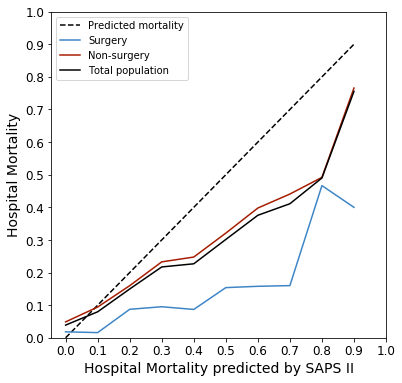

In [14]:
risk_seq = pd.DataFrame(np.arange(0, 1, 0.1), columns=['risk'])
eicu_can_pid['sapspred'] = eicu_can_pid.sapsii.apply(sapstosmr)
risk_seq['total'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.sapspred >= x) & (eicu_can_pid.sapspred < x+0.1)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.sapspred >= x) & (eicu_can_pid.sapspred < x+0.1)].shape[0])
risk_seq['surgery'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.sapspred >= x) & 
                                                                 (eicu_can_pid.sapspred < x+0.1) &
                                                                (eicu_can_pid.surgery == 1)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.sapspred >= x) & 
                                                    (eicu_can_pid.sapspred < x+0.1) &
                                                   (eicu_can_pid.surgery == 1)].shape[0])
risk_seq['non_surgery'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.sapspred >= x) & 
                                                                     (eicu_can_pid.sapspred < x+0.1) &
                                                                    (eicu_can_pid.surgery == 0)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.sapspred >= x) & 
                                                    (eicu_can_pid.sapspred < x+0.1) &
                                                   (eicu_can_pid.surgery == 0)].shape[0])



fig = plt.figure(figsize=(6,6))
plt.plot(risk_seq.risk, risk_seq.risk, label='Predicted mortality', linestyle='--', color='black')
plt.plot(risk_seq.risk, risk_seq.surgery, label='Surgery', color='#3d85c6')
plt.plot(risk_seq.risk, risk_seq.non_surgery, label='Non-surgery', color='#a61c00')
plt.plot(risk_seq.risk, risk_seq.total, label='Total population', color='black')
plt.ylim(0,1)
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.xlabel("Hospital Mortality predicted by SAPS II", fontsize=14)
plt.ylabel("Hospital Mortality", fontsize=14)
plt.legend()
plt.show()
# fig.savefig("Pics_tables/Figure_8.pdf")


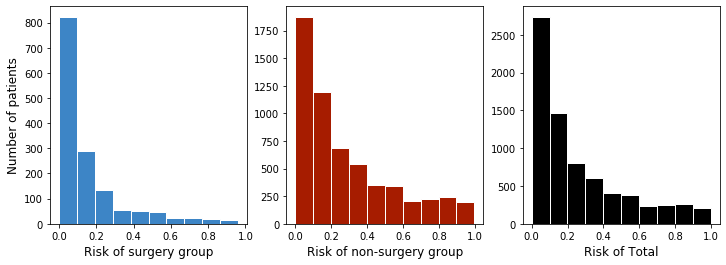

In [149]:
# distribution of three
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(eicu_can_pid[eicu_can_pid.surgery == 1].sapsii.apply(sapstosmr), color='#3d85c6', edgecolor='white')
ax1.set_xlabel("Risk of surgery group", fontsize=12)
ax1.set_ylabel("Number of patients", fontsize=12)
ax2.hist(eicu_can_pid[eicu_can_pid.surgery == 0].sapsii.apply(sapstosmr), color='#a61c00', edgecolor='white')
ax2.set_xlabel("Risk of non-surgery group", fontsize=12)
ax3.hist(eicu_can_pid.sapsii.apply(sapstosmr), color='black', edgecolor='white')
ax3.set_xlabel("Risk of Total", fontsize=12)
plt.show()
# fig.savefig("Pics_tables/SFigure_6.pdf")

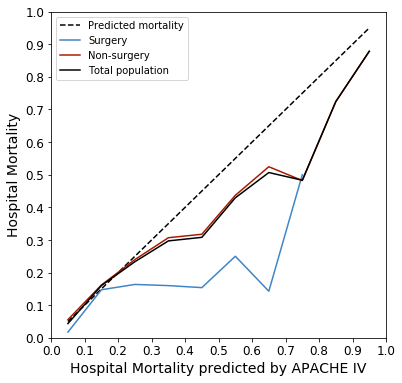

In [15]:
risk_seq = pd.DataFrame(np.arange(0.05, 1.05, 0.1), columns=['risk'])
# eicu_can_pid['sapspred'] = eicu_can_pid.sapsii.apply(sapstosmr)
risk_seq['total'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & (eicu_can_pid.phm < x+0.05)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & (eicu_can_pid.phm < x+0.05)].shape[0])
risk_seq['surgery'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & 
                                                                 (eicu_can_pid.phm < x+0.05) &
                                                                (eicu_can_pid.surgery == 1)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & 
                                                    (eicu_can_pid.phm < x+0.05) &
                                                   (eicu_can_pid.surgery == 1)].shape[0])
risk_seq['non_surgery'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & 
                                                                     (eicu_can_pid.phm < x+0.05) &
                                                                    (eicu_can_pid.surgery == 0)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & 
                                                    (eicu_can_pid.phm < x+0.05) &
                                                   (eicu_can_pid.surgery == 0)].shape[0])
fig = plt.figure(figsize=(6,6))
plt.plot(risk_seq.risk, risk_seq.risk, label='Predicted mortality', linestyle='--', color='black')
plt.plot(risk_seq.risk, risk_seq.surgery, label='Surgery', color='#3d85c6')
plt.plot(risk_seq.risk, risk_seq.non_surgery, label='Non-surgery', color='#a61c00')
plt.plot(risk_seq.risk, risk_seq.total, label='Total population', color='black')
plt.ylim(0,1)
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.xlabel("Hospital Mortality predicted by APACHE IV", fontsize=14)
plt.ylabel("Hospital Mortality", fontsize=14)
plt.legend()
plt.show()
# fig.savefig("Pics_tables/Figure_9.pdf")


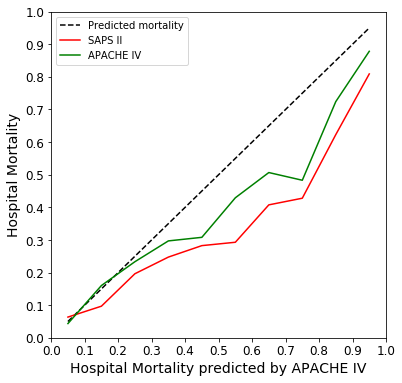

In [18]:
# combine two figures above
fig = plt.figure(figsize=(6,6))
risk_seq['saps'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.sapspred >= x) & (eicu_can_pid.sapspred < x+0.1)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.sapspred >= x) & (eicu_can_pid.sapspred < x+0.1)].shape[0])
risk_seq['apache'] = risk_seq.risk.apply(lambda x: eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & (eicu_can_pid.phm < x+0.05)].mortality.sum() /
                                       eicu_can_pid[(eicu_can_pid.phm >= x-0.05) & (eicu_can_pid.phm < x+0.05)].shape[0])
plt.plot(risk_seq.risk, risk_seq.risk, label='Predicted mortality', linestyle='--', color='black')
plt.plot(risk_seq.risk, risk_seq.saps, label='SAPS II', color='red')
plt.plot(risk_seq.risk, risk_seq.apache, label='APACHE IV', color='green')
plt.ylim(0,1)
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=12)
plt.xlabel("Hospital Mortality predicted by APACHE IV", fontsize=14)
plt.ylabel("Hospital Mortality", fontsize=14)
plt.legend()
plt.show()
fig.savefig("Pics_tables/SFigure_8.pdf")

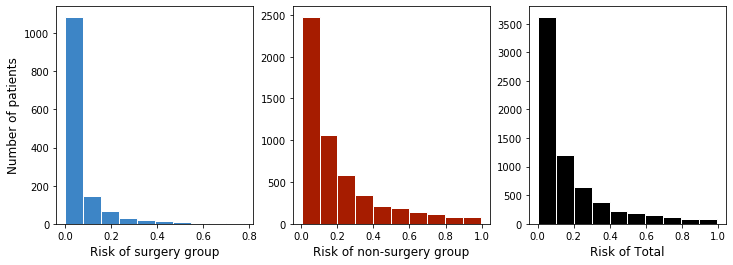

In [152]:
# distribution of three
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(eicu_can_pid[eicu_can_pid.surgery == 1].phm, color='#3d85c6', edgecolor='white')
ax1.set_xlabel("Risk of surgery group", fontsize=12)
ax1.set_ylabel("Number of patients", fontsize=12)
ax2.hist(eicu_can_pid[eicu_can_pid.surgery == 0].phm, color='#a61c00', edgecolor='white')
ax2.set_xlabel("Risk of non-surgery group", fontsize=12)
ax3.hist(eicu_can_pid.phm, color='black', edgecolor='white')
ax3.set_xlabel("Risk of Total", fontsize=12)
plt.show()
# fig.savefig("Pics_tables/SFigure_7.pdf")

In [169]:
# Now we need to calculate the smrs

observe_d = [
    mval_df[mval_df.cluster < 2].hosp_death.sum(),
    mval_df[mval_df.cluster > 1].hosp_death.sum(),
    mval_df.hosp_death.sum(),
    eicu_can_pid[eicu_can_pid.surgery == 1].mortality.sum(),
    eicu_can_pid[eicu_can_pid.surgery == 0].mortality.sum(),
    eicu_can_pid.mortality.sum(),
    eicu_can_pid[eicu_can_pid.surgery == 1].mortality.sum(),
    eicu_can_pid[eicu_can_pid.surgery == 0].mortality.sum(),
    eicu_can_pid.mortality.sum()    
]

expect_d = [
    mval_df[mval_df.cluster < 2].sapsii.apply(sapstosmr).sum(),
    mval_df[mval_df.cluster > 1].sapsii.apply(sapstosmr).sum(),
    mval_df.sapsii.apply(sapstosmr).sum(),
    eicu_can_pid[eicu_can_pid.surgery == 1].sapsii.apply(sapstosmr).sum(),
    eicu_can_pid[eicu_can_pid.surgery == 0].sapsii.apply(sapstosmr).sum(),
    eicu_can_pid.sapsii.apply(sapstosmr).sum(),
    eicu_can_pid[eicu_can_pid.surgery == 1].phm.sum(),
    eicu_can_pid[eicu_can_pid.surgery == 0].phm.sum(),
    eicu_can_pid.phm.sum()  
]

smr_df = pd.DataFrame({'o': observe_d, 'e': expect_d})
smr_df['smr'] = smr_df.o / smr_df.e
smr_df['smr_95down'] = ((np.sqrt(smr_df.o) - 1.96*0.5)**2)/ smr_df.e
smr_df['smr_95up'] = ((np.sqrt(smr_df.o) + 1.96*0.5)**2)/ smr_df.e
smr_df

,o,e,smr,smr_95down,smr_95up
0,213,569.555851,0.373976,0.325438,0.425886
1,1036,1356.866621,0.763524,0.717737,0.810726
2,1249,1926.422472,0.648352,0.612893,0.684808
3,73,230.612106,0.316549,0.248097,0.393330
4,1125,1672.962423,0.672460,0.633738,0.712330
5,1198,1903.574528,0.629342,0.594209,0.665485
6,73,95.836256,0.761716,0.596999,0.946475
7,1125,1049.266072,1.072178,1.010440,1.135747
8,1198,1145.102329,1.046195,0.987790,1.106277


In [ ]:
from scipy.stats import chi2
HL_12['apache_decile'] = pd.qcut(HL_12['apachescore'], 10)
print (HL_12['mortality'].groupby(HL_12.apache_decile).sum())
print (HL_12['phm'].groupby(HL_12.apache_decile).sum())
chi2_12 = np.sum((HL_12['mortality'].groupby(HL_12.apache_decile).sum() - HL_12['phm'].groupby(HL_12.apache_decile).sum())**2\
/HL_12['phm'].groupby(HL_12.apache_decile).sum() + ((HL_12['mortality'].groupby(HL_12.apache_decile).count()-\
                                                   HL_12['mortality'].groupby(HL_12.apache_decile).sum()) -\
                (HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum()))**2/\
                (HL_12['phm'].groupby(HL_12.apache_decile).count() - HL_12['phm'].groupby(HL_12.apache_decile).sum()))
pval_12 = 1 - chi2.cdf(chi2_12, 8)
print (chi2_12, pval_12)

In [179]:
# Hosmer-Lemeshow C statistic
HL_dfs = [
    pd.DataFrame({'sapspred': saps_pred[mval_df.cluster < 2], 'mortality': mval_df[mval_df.cluster < 2].hosp_death}),
    pd.DataFrame({'sapspred': saps_pred[mval_df.cluster > 1], 'mortality': mval_df[mval_df.cluster > 1].hosp_death}),
    pd.DataFrame({'sapspred': saps_pred, 'mortality': mval_df.hosp_death}),
    eicu_can_pid[eicu_can_pid.surgery == 1][['sapspred', 'mortality']],
    eicu_can_pid[eicu_can_pid.surgery == 0][['sapspred', 'mortality']],
    eicu_can_pid[['sapspred', 'mortality']],
    eicu_can_pid[eicu_can_pid.surgery == 1][['phm', 'mortality']],
    eicu_can_pid[eicu_can_pid.surgery == 0][['phm', 'mortality']],
    eicu_can_pid[['phm', 'mortality']]
]


In [190]:
from scipy.stats import chi2
chis = []
pvals = []
for df in HL_dfs:
    df['score_decile'] = pd.qcut(df.iloc[:,0], 10)
    print (df.iloc[:, 1].groupby(df.iloc[:, 2]).sum())
    print (df.iloc[:, 0].groupby(df.iloc[:, 2]).sum())
    chi = np.sum((df.iloc[:, 1].groupby(df.iloc[:, 2]).sum() - \
                  df.iloc[:, 0].groupby(df.iloc[:, 2]).sum())**2 /\
                  df.iloc[:, 0].groupby(df.iloc[:, 2]).sum() +\
                  ((df.iloc[:, 1].groupby(df.iloc[:, 2]).count() - df.iloc[:, 1].groupby(df.iloc[:, 2]).sum()) -\
                   (df.iloc[:, 0].groupby(df.iloc[:, 2]).count() - df.iloc[:, 0].groupby(df.iloc[:, 2]).sum()))**2 /\
                   (df.iloc[:, 0].groupby(df.iloc[:, 2]).count() - df.iloc[:, 0].groupby(df.iloc[:, 2]).sum()))
    pval = 1- chi2.cdf(chi, 8)
    chis.append(chi)
    pvals.append(pval)
smr_df['chi'] = chis
smr_df['pval'] = pvals


score_decile
(-0.000575, 0.0372]     2
(0.0372, 0.0582]        4
(0.0582, 0.0877]        8
(0.0877, 0.117]         8
(0.117, 0.153]         19
(0.153, 0.196]         15
(0.196, 0.247]         24
(0.247, 0.326]         25
(0.326, 0.484]         43
(0.484, 0.976]         65
Name: mortality, dtype: int64
score_decile
(-0.000575, 0.0372]      7.274879
(0.0372, 0.0582]        11.818077
(0.0582, 0.0877]        21.255794
(0.0877, 0.117]         28.401019
(0.117, 0.153]          37.605698
(0.153, 0.196]          51.755770
(0.196, 0.247]          54.387090
(0.247, 0.326]          76.250698
(0.326, 0.484]         108.843886
(0.484, 0.976]         171.962941
Name: sapspred, dtype: float64
score_decile
(0.00861, 0.0794]     38
(0.0794, 0.128]       51
(0.128, 0.167]        42
(0.167, 0.23]         74
(0.23, 0.285]         67
(0.285, 0.37]         89
(0.37, 0.461]         99
(0.461, 0.598]       166
(0.598, 0.753]       177
(0.753, 0.997]       233
Name: mortality, dtype: int64
score_decile
(0.0086

/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


score_decile
(-0.000575, 0.0293]     17
(0.0293, 0.0522]        31
(0.0522, 0.0794]        42
(0.0794, 0.117]         52
(0.117, 0.153]          53
(0.153, 0.23]           87
(0.23, 0.326]          145
(0.326, 0.461]         148
(0.461, 0.681]         232
(0.681, 0.997]         391
Name: mortality, dtype: int64
score_decile
(-0.000575, 0.0293]     15.600198
(0.0293, 0.0522]        34.603432
(0.0522, 0.0794]        48.191675
(0.0794, 0.117]         80.617489
(0.117, 0.153]          79.706518
(0.153, 0.23]          167.258873
(0.23, 0.326]          201.932588
(0.326, 0.461]         263.640595
(0.461, 0.681]         408.370756
(0.681, 0.997]         603.652404
Name: sapspred, dtype: float64
score_decile
(0.0009, 0.00819]     1
(0.00819, 0.013]      2
(0.013, 0.0183]       0
(0.0183, 0.0245]      1
(0.0245, 0.0324]      2
(0.0324, 0.0424]      1
(0.0424, 0.0565]      3
(0.0565, 0.0876]      5
(0.0876, 0.171]      22
(0.171, 0.778]       23
Name: mortality, dtype: int64
score_decile
(0.0009

/Users/gaoshaowei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [192]:
smr_df.to_excel("Pics_tables/Table_1.xlsx")

In [193]:
eicu_can_pid.shape

(7351, 7)